# VO2max Prediction Using Treadmill Maximal Exercise Tests and Machine Learning Techniques

In [70]:
# import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal
from collections import Counter
from sklearn.utils import indexable
from sklearn.utils import resample
from sklearn.utils.validation import _num_samples
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from itertools import chain
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, MultiTaskLassoCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import ceil, floor
from scipy.signal import welch
from scipy.stats import linregress, shapiro

In [71]:
# load subject dataset
subject_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/subject-info.csv')

# basic information
display(subject_data.head())
print("Initial Dataset Info:")
print(subject_data.info())
print(subject_data.describe())

,Age,Weight,Height,Humidity,Temperature,Sex,ID,ID_test
0,10.8,48.8,163.0,39.0,20.7,1,543,543_1
1,11.8,41.0,150.0,41.0,22.3,1,11,11_1
2,12.2,46.0,160.0,37.0,21.5,0,829,829_1
3,13.2,71.0,190.0,49.0,23.8,1,284,284_1
4,13.7,53.8,169.7,40.0,25.3,0,341,341_1


Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          992 non-null    float64
 1   Weight       992 non-null    float64
 2   Height       992 non-null    float64
 3   Humidity     962 non-null    float64
 4   Temperature  962 non-null    float64
 5   Sex          992 non-null    int64  
 6   ID           992 non-null    int64  
 7   ID_test      992 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 62.1+ KB
None
              Age      Weight      Height    Humidity  Temperature  \
count  992.000000  992.000000  992.000000  962.000000   962.000000   
mean    28.979133   73.383367  174.913508   48.211435    22.818565   
std     10.076653   12.005361    7.950027    8.560991     2.784066   
min     10.800000   41.000000  150.000000   23.700000    15.000000   
25%     21.100000   66.000000  170.0

In [72]:
# load measurement dataset
measurement_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/test_measure.csv')

# basic information
print("Measurement Data Overview:")
display(measurement_data.head())
print("Measurement Dataset Info:")
print(measurement_data.info())

Measurement Data Overview:


,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID
0,0,5.0,63.0,478.0,360.0,27,13.3,2_1,2
1,2,5.0,75.0,401.0,295.0,23,10.3,2_1,2
2,4,5.0,82.0,449.0,319.0,29,12.2,2_1,2
3,7,5.0,87.0,461.0,340.0,28,12.8,2_1,2
4,9,5.0,92.0,574.0,417.0,28,14.6,2_1,2


Measurement Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575087 entries, 0 to 575086
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   time     575087 non-null  int64  
 1   Speed    575087 non-null  float64
 2   HR       574106 non-null  float64
 3   VO2      570216 non-null  float64
 4   VCO2     570216 non-null  float64
 5   RR       575087 non-null  int64  
 6   VE       575087 non-null  float64
 7   ID_test  575087 non-null  object 
 8   ID       575087 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 39.5+ MB
None


## Feature Selection

The feature selection process is based on the Paper: Heart Rate Variability Based Estimation of Maximal Oxygen
Uptake in Athletes Using Supervised Regression Models .

### Data Cleaning and Pre-processing

In [73]:
# check if there are missing values
print("Missing Values per Column:")
print(measurement_data.isnull().sum())

Missing Values per Column:
time          0
Speed         0
HR          981
VO2        4871
VCO2       4871
RR            0
VE            0
ID_test       0
ID            0
dtype: int64


In [74]:
def pipeline_data_cleaning(data):
    """
    Preprocess the data by removing missing values, outliers, and ensuring HR and VO2 are in-phase.
    """
    
    # remove rows with missing target variable (HR, VO2)
    measurement_data_cleaned = data.dropna(subset=['HR', 'VO2'])

    # Check how many rows are removed
    print(f'Rows removed due to missing HR or VO2: {len(data) - len(measurement_data_cleaned)}')

    # Remove RR intervals outside the range of 5-50 breaths per minute (outliers)
    measurement_data_cleaned['RR'] = np.where((measurement_data_cleaned['RR'] < 5) | (measurement_data_cleaned['RR'] > 50), np.nan, measurement_data_cleaned['RR'])

    # linear interpolation to fill missing values
    measurement_data_cleaned['RR'] = measurement_data_cleaned['RR'].interpolate(method='linear')

    # Check for NaN values after interpolation
    print("Remaining Missing Values after Interpolation:")
    print(measurement_data_cleaned.isnull().sum())

    # remove data points where HR and VO2 are out of ohase
    delta_hr = np.diff(measurement_data_cleaned['HR'])
    delta_vo2max = np.diff(measurement_data_cleaned['VO2'])

    # Ensure indices match before masking
    measurement_data_cleaned = measurement_data_cleaned.iloc[:-1]  # Drop the last row
    in_phase_mask = (delta_hr * delta_vo2max) > 0  # Create a mask for in-phase points
    measurement_data_cleaned =  measurement_data_cleaned[in_phase_mask]

    #  remove where consecutive HR differs more by than 30 bpm
    measurement_data_cleaned['HR_diff'] = measurement_data_cleaned['HR'].diff().abs()
    measurement_data_cleaned = measurement_data_cleaned[measurement_data_cleaned['HR_diff'] <= 30]

    # remove objects with less than 5 minutes of data
    measurement_data_cleaned['time'] = measurement_data_cleaned['time'].astype(float)  # make it numeirc
    measurement_data_cleaned = measurement_data_cleaned[measurement_data_cleaned['time'] >= 300]

    # check dataset
    print(f'Dataset size after cleaning: {measurement_data_cleaned.shape}')

    # split data into exercise and recovery phases
    exercise_data = measurement_data_cleaned[measurement_data_cleaned['Speed'] >= 5]  # Exercise phase
    recovery_data = measurement_data_cleaned[measurement_data_cleaned['Speed'] < 5]  # Recovery phase
    
    return exercise_data, recovery_data

exercise_data, recovery_data = pipeline_data_cleaning(measurement_data)
# shapes of dataframes
print(f'Exercise data size: {exercise_data.shape}')
print(f'Recovery data size: {recovery_data.shape}')

Rows removed due to missing HR or VO2: 5840
Remaining Missing Values after Interpolation:
time       0
Speed      0
HR         0
VO2        0
VCO2       0
RR         0
VE         0
ID_test    0
ID         0
dtype: int64
Dataset size after cleaning: (100039, 10)
Exercise data size: (85872, 10)
Recovery data size: (14167, 10)


C:\Users\Eva\AppData\Local\Temp\ipykernel_25540\3189033610.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement_data_cleaned['RR'] = np.where((measurement_data_cleaned['RR'] < 5) | (measurement_data_cleaned['RR'] > 50), np.nan, measurement_data_cleaned['RR'])
C:\Users\Eva\AppData\Local\Temp\ipykernel_25540\3189033610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement_data_cleaned['RR'] = measurement_data_cleaned['RR'].interpolate(method='linear')


In [75]:
# Remove all data from test IDs with missing HR or VO2
#difference = pd.merge(merged_data, measurement_data_cleaned, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
#exclude_ids = difference['ID_test'].unique()
#measurement_data_cleaned = measurement_data_cleaned[~measurement_data_cleaned['ID_test'].isin(exclude_ids)]

## Feature Extraction

In [76]:
def poincare_plot(data):
        
    # Sample RR intervals
    rr_intervals = data['RR'].values
    # Calculate consecutive differences for Poincaré plot
    rr_diff1 = rr_intervals[:-1]  # RR interval at time t
    rr_diff2 = rr_intervals[1:]  # RR interval at time t+1

    # Calculate mean of RR intervals
    rr_mean = np.mean(rr_intervals)

    # Calculate SD1 and SD2
    sd1 = np.sqrt(0.5) * np.std(rr_diff2 - rr_diff1)
    sd2 = np.sqrt(2 * np.std(rr_diff1)**2 - sd1**2)

    # Line of identity
    identity_line = np.linspace(min(rr_intervals), max(rr_intervals), 100)

    # Create Poincaré plot
    plt.figure(figsize=(8, 8))
    plt.scatter(rr_diff1, rr_diff2, alpha=0.6, label="RR intervals")
    plt.plot(identity_line, identity_line, color="red", linestyle="--", label="Line of Identity")
    plt.xlim(min(rr_intervals), max(rr_intervals)+20)
    plt.ylim(min(rr_intervals), max(rr_intervals)+20)

    # SD1 and SD2 ellipse visualization
    mean_rr = [np.mean(rr_diff1), np.mean(rr_diff2)]
    ellipse_angle = 45
    ellipse_sd1 = plt.Circle(mean_rr, sd1, color="blue", fill=False, label="SD1")
    ellipse_sd2 = plt.Circle(mean_rr, sd2, color="green", fill=False, label="SD2")
    plt.gca().add_patch(ellipse_sd1)
    plt.gca().add_patch(ellipse_sd2)

    # Formatting
    plt.title("Poincaré Plot")
    plt.xlabel("RR Interval (n)")
    plt.ylabel("RR Interval (n+1)")
    plt.legend()
    plt.grid(alpha=0.4)
    plt.axis("equal")
    plt.show()

    # Print SD1 and SD2
    print(f"SD1: {sd1:.2f} ms")
    print(f"SD2: {sd2:.2f} ms")



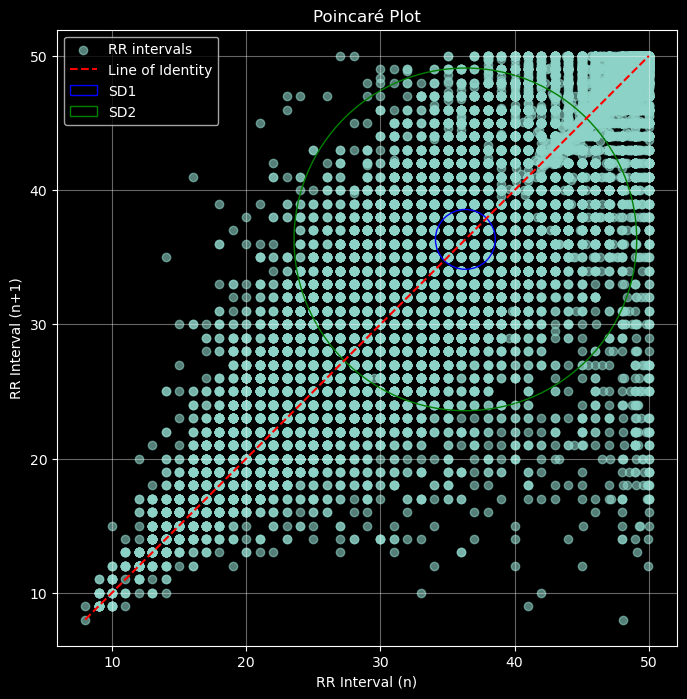

SD1: 2.23 ms
SD2: 12.77 ms


In [77]:
poincare_plot(exercise_data)

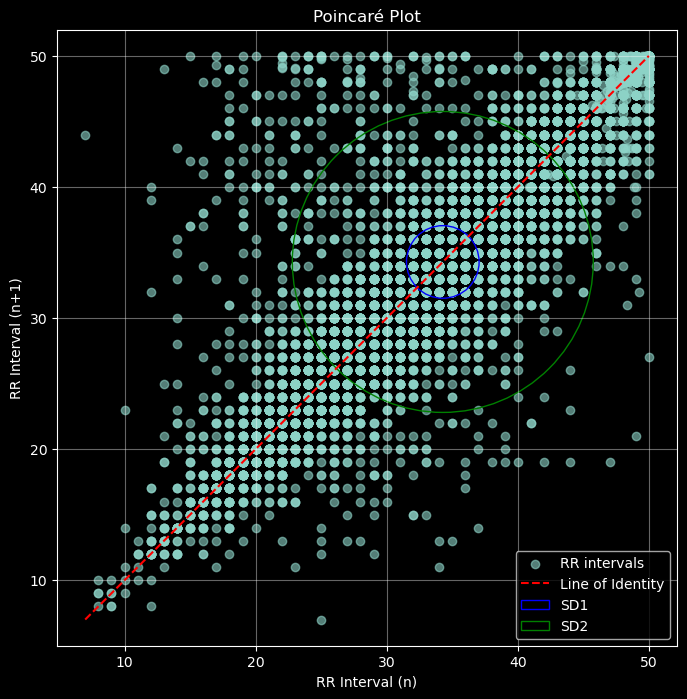

SD1: 2.77 ms
SD2: 11.48 ms


In [78]:
poincare_plot(recovery_data)

In [79]:

# Function to calculate slopes over time for a feature

def calculate_slopes(df, feature):
    """
    Calculate the slope of a feature over time using linear regression.

    Parameters:
    df (pd.DataFrame): DataFrame containing the 'time' and feature columns.
    feature (str): The feature column for which the slope is calculated.

    Returns:
    float: Slope of the feature over time. NaN if the input DataFrame is empty.
    """
    if len(df) == 0:  # Handle empty DataFrame
        return np.nan
    else:
        # Use linear regression to calculate the slope
        slope = linregress(df['time'], df[feature]).slope
        return slope
    



In [80]:
 # Function to compute HR & HRV features for a given data segment

def compute_hr_features(segment: pd.DataFrame) -> dict:
    """
    Calculate heart rate variability (HRV) features and additional metrics from a data segment.

    Parameters:
    segment (pd.DataFrame): A DataFrame containing the segment data.

    Returns:
    dict: A dictionary of computed features.
    """

    hr = segment['HR'].values
    time = segment['time'].values
    rr_intervals = segment['RR'].values 

    # Time-Domain-Features
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))  # RMSSD: Root Mean Square of Successive Differences
    pnn20 = np.mean(np.abs(np.diff(rr_intervals)) > 0.5) * 100  # % of differences > 20 ms
    pnn50 = np.mean(np.abs(np.diff(rr_intervals)) > 1.25) * 100  # % of differences > 50 ms
    nni20 = np.sum(np.abs(np.diff(rr_intervals)) > 0.5)  # Count of differences > 20 ms
    nni50 = np.sum(np.abs(np.diff(rr_intervals)) > 1.25)  # Count of differences > 50 ms
    nni_range = np.max(rr_intervals) - np.min(rr_intervals)  # Range of RR intervals
    
    # Frequency-Domain-Features
    fs = 4  # Sampling frequency in Hz (adjust based on your data)
    f, pxx = welch(rr_intervals, fs, nperseg=len(rr_intervals))  # Welch's power spectral density
    vlf_power = np.trapz(pxx[(f >= 0.003) & (f < 0.04)], f[(f >= 0.003) & (f < 0.04)])  # VLF band
    lf_power = np.trapz(pxx[(f >= 0.04) & (f < 0.15)], f[(f >= 0.04) & (f < 0.15)])  # LF band
    hf_power = np.trapz(pxx[(f >= 0.15) & (f < 0.4)], f[(f >= 0.15) & (f < 0.4)])  # HF band
    lf_nu_power = lf_power / (vlf_power + lf_power + hf_power)  # LF normalized power

    # Nonlinear Features (Poincare Plot, DFA)
    sd1 = np.sqrt(0.5) * np.std(rr_intervals[1:] - rr_intervals[:-1])  # Short-term variability
    sd2 = np.sqrt(2 * np.std(rr_intervals[:-1]) ** 2 - sd1 ** 2)  # Long-term variability
    dfa_a1 = np.std(rr_intervals[:len(rr_intervals)//2]) / np.std(rr_intervals)  # Placeholder for DFA Alpha-1
    
    # Slope-Based Features
    slope_nni = np.polyfit(time, rr_intervals, 1)[0]  # Slope of NN intervals over time

    # Additional Features
    max_hr = max(hr)  # Max HR in the segment
    min_hr = min(hr)  # Min HR in the segment
    vo2_max = segment['VO2'].max()  # Max VO2 in the segment
    
    # Slopes for Poincare Plot Features
    # slope_sd1 = np.polyfit(time, [sd1] * len(time), 1)[0]
    # slope_sd2 = np.polyfit(time, [sd2] * len(time), 1)[0]

    # Time-based features
    max_speed = segment['Speed'].max()
    slope_sp25 = calculate_slopes(segment[segment['Speed'] <= max_speed * 0.25], 'HR')
    slope_sp50 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.5) & (segment['Speed'] > max_speed * 0.25)], 'HR')
    slope_sp75 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.75) & (segment['Speed'] > max_speed * 0.5)], 'HR')
    slope_sp100 = calculate_slopes(segment[(segment['Speed'] > max_speed * 0.75)], 'HR')
    rt25 = segment.loc[segment['time'] <= segment['time'].max() * 0.25, 'HR'].corr(segment['time'])
    rt50 = segment.loc[(segment['time'] >= segment['time'].max() * 0.25) & (segment['time'] < segment['time'].max() * 0.5), 'HR'].corr(segment['time'])
    rt75 = segment.loc[(segment['time'] >= segment['time'].max() * 0.5) & (segment['time'] < segment['time'].max() * 0.75), 'HR'].corr(segment['time'])
    rsp75 = segment.loc[segment['Speed'] <= max_speed * 0.75, 'HR'].corr(segment['Speed'])
    rsp25 = segment.loc[segment['Speed'] <= max_speed * 0.25, 'HR'].corr(segment['Speed'])
    time_sp25 = segment[segment['Speed'] >= max_speed * 0.25]['time'].min()
    time_hr25 = segment[segment['HR'] >= max_hr * 0.25]['time'].min()
    time_hr50 = segment[segment['HR'] >= max_hr * 0.5]['time'].min()
    time_hr75 = segment[segment['HR'] >= max_hr * 0.75]['time'].min()
    duration_hr60 = len(segment[(segment['HR'] >= max_hr * 0.5) & (segment['HR'] < max_hr * 0.6)]) * (segment['time'].diff().mean())
    duration_hr70 = len(segment[(segment['HR'] >= max_hr * 0.6) & (segment['HR'] < max_hr * 0.7)]) * (segment['time'].diff().mean())
    duration_hr80 = len(segment[(segment['HR'] >= max_hr * 0.7) & (segment['HR'] < max_hr * 0.8)]) * (segment['time'].diff().mean())
    duration_hr90 = len(segment[(segment['HR'] >= max_hr * 0.8) & (segment['HR'] < max_hr * 0.9)]) * (segment['time'].diff().mean())
    duration_hr100 = len(segment[(segment['HR'] >= max_hr * 0.9) & (segment['HR'] <= max_hr)]) * (segment['time'].diff().mean())

    
    # Feature Dictionary
    Features = {'RMSSD': rmssd,
        'PNN20': pnn20,
        'PNN50': pnn50,
        'NNI20': nni20,
        'NNI50': nni50,
        'NNI_Range': nni_range,
        'VLF_Power': vlf_power,
        'LF_Power': lf_power,
        'HF_Power': hf_power,
        'LF_Nu_Power': lf_nu_power,
        'SD1': sd1,
        'SD2': sd2,
        'DFA_A1': dfa_a1,
        'Slope_NNI': slope_nni,
        'Slope_Speed25': slope_sp25,
        'Slope_Speed50': slope_sp50,
        'Slope_Speed75': slope_sp75,
        'Slope_Speed100': slope_sp100,
        'RT25': rt25,
        'RT50': rt50,
        'RT75': rt75,
        'RSP75': rsp75,
        'RSP25': rsp25,
        'Time_SP25': time_sp25,
        'Time_HR25': time_hr25,
        'Time_HR50': time_hr50,
        'Time_HR75': time_hr75,
        'DurationHR60': duration_hr60,
        'DurationHR70': duration_hr70,
        'DurationHR80': duration_hr80,
        'DurationHR90': duration_hr90,
        'DurationHR100': duration_hr100,
        'VO2max': segment['VO2'].max(),
    }
    
    return Features

In [81]:
# Function to calculate features for each segment
def calculate_features_per_segment(df, test_column):
    """
    Calculate features for each segment grouped by the specified column.

    Parameters:
    df (pd.DataFrame): The input data.
    test_column (str): The column to group by (e.g., test IDs).

    Returns:
    pd.DataFrame: DataFrame of computed features for each segment.
    """
    all_features = []  # List to store features for all segments

    for test_id, df_segment in df.groupby(test_column):  # Group by the test column
        features = compute_hr_features(df_segment)  # Compute features for the segment
        features[test_column] = test_id  # Add the test ID to the features
        all_features.append(features)  # Append the features

    return pd.DataFrame(all_features)  # Return all features as a DataFrame

In [82]:
# just for testing the feature calculat
# for test_id, df_segment in merged_data_cleaned.groupby('ID_test'):
#     #print(test_id)
#     if test_id == '3_1':
#         test_segment = merged_data_cleaned[merged_data_cleaned['ID_test'] == test_id]
#         break
# compute_hr_features(test_segment)

In [83]:
# Function to normalize numerical features in a DataFrame
def normalize_features(dataframe):
    """
    Normalize numerical features in a DataFrame using StandardScaler.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with normalized numerical features.
    """
    # Identify numerical columns (excluding target variables or IDs)
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Initialize StandardScaler (scales data to mean=0, std=1)
    scaler = StandardScaler()

    # Fit and transform numerical features
    normalized_data = scaler.fit_transform(dataframe[numerical_features])

    # Convert normalized data back to a DataFrame for readability
    normalized_df = pd.DataFrame(normalized_data, columns=numerical_features)

    # Copy the original DataFrame and replace numerical columns with normalized values
    normalized_features = dataframe.copy()
    normalized_features[numerical_features] = normalized_df

    return normalized_features



In [110]:
def pipeline_feature_extraction(data, subject_data):
    """
    Preprocess the data by removing missing values, outliers, and ensuring HR and VO2 are in-phase, 
    all well as merging with patient data normalizing the data.
    """
    
    additional_features = calculate_features_per_segment(data, 'ID_test')#ID_test_y')
    
    #new_features['ID_test'] = new_features['ID_test_y']
    merged_data = pd.merge(subject_data, additional_features, on='ID_test', how='inner')
    
    normalized_features = normalize_features(merged_data)
    
    return normalized_features

normalized_features_exercise = pipeline_feature_extraction(exercise_data, subject_data)
normalized_features_recovery = pipeline_feature_extraction(recovery_data, subject_data)

# shapes of dataframes
print(f'Exercise data size: {normalized_features_exercise.shape}')
print(f'Recovery data size: {normalized_features_recovery.shape}')

c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\

Exercise data size: (981, 41)
Recovery data size: (317, 41)


C:\Users\Eva\AppData\Local\Temp\ipykernel_25540\1876387332.py:32: RuntimeWarning: invalid value encountered in scalar divide
  lf_nu_power = lf_power / (vlf_power + lf_power + hf_power)  # LF normalized power
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\ana

In [86]:
# Function to perform Shapiro-Wilk test for normality on each numerical feature
def shapiro_wilk_test(dataframe):
    """
    Perform the Shapiro-Wilk test for normality on all numerical features in the DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    tuple: A DataFrame with Shapiro-Wilk test results (statistic and p-value) 
           and another DataFrame identifying non-normally distributed features.
    """
    # Identify numerical columns (excluding target variables or IDs)
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Dictionary to store Shapiro-Wilk test results
    shapiro_results = {}

    for column in numerical_features:
        # Perform Shapiro-Wilk test for the column
        stat, p = shapiro(dataframe[column])
        shapiro_results[column] = {'Statistic': stat, 'p-value': p}

    # Convert results dictionary to a DataFrame
    shapiro_results_df = pd.DataFrame(shapiro_results).T
    shapiro_results_df.columns = ['Shapiro Statistic', 'p-value']

    # Identify features that are not normally distributed (p-value <= 0.05)
    non_normal_features = shapiro_results_df[shapiro_results_df['p-value'] <= 0.05]

    return shapiro_results_df, non_normal_features



In [87]:
# Run Shapiro-Wilk test and display results for exercise and recovery data
print("Shapiro-Wilk Test Results for Exercise Data:")
shapiro_results_exercise, non_normal_features_exercise = shapiro_wilk_test(normalized_features_exercise)
#print(shapiro_results_exercise)  # Uncomment to display the full results for all features

print("Shapiro-Wilk Test Results for Recovery Data:")
shapiro_results_recovery, non_normal_features_recovery = shapiro_wilk_test(normalized_features_recovery)
#print(shapiro_results_recovery)  # Uncomment to display the full results for all features

# Display features that are not normally distributed
print("\nExercise Features that are NOT Normally Distributed:")
print(non_normal_features_exercise)

print("\nRecovery Features that are NOT Normally Distributed:")
print(non_normal_features_recovery)

Shapiro-Wilk Test Results for Exercise Data:
Shapiro-Wilk Test Results for Recovery Data:

Exercise Features that are NOT Normally Distributed:
                Shapiro Statistic       p-value
Age                      0.960223  1.092042e-15
Weight                   0.981725  9.514245e-10
Height                   0.996589  3.198692e-02
Sex                      0.423068  2.996888e-48
ID                       0.959026  6.033147e-16
RMSSD                    0.964771  1.174175e-14
PNN20                    0.962115  2.863421e-15
NNI_Range                0.991673  2.444314e-05
VLF_Power                0.020442  6.173173e-57
LF_Power                 0.799519  3.997152e-33
HF_Power                 0.743751  2.254826e-36
SD1                      0.965043  1.362248e-14
SD2                      0.992437  6.603047e-05
DFA_A1                   0.961254  1.839111e-15
Slope_NNI                0.959092  6.231946e-16
Slope_Speed100           0.915350  5.672738e-23
RT75                     0.573165  1.229

c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


A lot features are not normally distributed -> Feature Selection Methods that do not assume the data to be normally distributed (Mutual Information, Spearson Coefficient)

### Feature Correlation

In [88]:
# Identify and visualize highly correlated features
def correlated_features(dataframe, threshold=0.7, plot_result=True):
    """
    Identifies pairs of highly correlated features based on the given threshold and visualizes the correlation matrix.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        threshold (float): The correlation coefficient threshold to identify highly correlated features. Default is 0.7.

    Returns:
        pd.DataFrame: A dataframe containing pairs of highly correlated features.
    """
    # Calculate the correlation matrix
    correlation_matrix = dataframe.corr()
    
    if plot_result == True:
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.show()

    # Find highly correlated feature pairs (off-diagonal elements > threshold)
    highly_correlated_pairs = correlation_matrix.where(
        (correlation_matrix.abs() > threshold) & (np.eye(correlation_matrix.shape[0]) == 0)
    ).stack()
    highly_correlated_pairs = pd.DataFrame(highly_correlated_pairs).T

    if not highly_correlated_pairs.empty:
        print("\nHighly Correlated Feature Pairs:")
        print(highly_correlated_pairs)

    return highly_correlated_pairs


In [89]:

# 3. Korrelation mit dem Zielwert
#correlation_with_target = normalized_features.corr()[target_column].drop(target_column)

# Features mit starker Korrelation zum Zielwert
#strongly_correlated_features = correlation_with_target[correlation_with_target.abs() > 0.5]
#print("Features mit starker Korrelation zum Zielwert:")
#print(strongly_correlated_features)

# 5. Mutual Information für nicht-lineare Zusammenhänge
#mi_scores = mutual_info_regression(features, target)
#mi_scores_df = pd.Series(mi_scores, index=features.columns).sort_values(ascending=False)
#print("\nMutual Information Scores:")
#print(mi_scores_df)

# 6. Scatterplots für interessante Features
#top_features = mi_scores_df.head(5).index  # Die 5 wichtigsten Features
#for feature in top_features:
 #   plt.figure(figsize=(6, 4))
  #  sns.scatterplot(x=features[feature], y=target)
   # plt.title(f"Zusammenhang zwischen {feature} und Zielwert")
    #plt.xlabel(feature)
    #plt.ylabel(target_column)
    #plt.show()


In [90]:
# Remove highly correlated features
from collections import Counter
def remove_correlated_features(dataframe, highly_correlated_pairs):
    """
    Removes one feature from each pair of highly correlated features.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        highly_correlated_pairs (pd.DataFrame): Dataframe containing pairs of highly correlated features.

    Returns:
        pd.DataFrame: The dataframe with highly correlated features removed.
    """
    # Flatten pairs to count occurrences of each feature
    flat_features = [item for pair in highly_correlated_pairs for item in pair]
    feature_counts = Counter(flat_features)

    # Initialize sets to keep track of features to keep and drop
    features_to_keep = set()
    features_to_drop = set()

    # Process each pair to decide which feature to drop
    for feature1, feature2 in highly_correlated_pairs:
        # If neither feature is already marked for keeping, drop the less frequent one
        if feature1 not in features_to_keep and feature2 not in features_to_keep:
            if feature_counts[feature1] >= feature_counts[feature2]:
                features_to_keep.add(feature1)
                features_to_drop.add(feature2)
            else:
                features_to_keep.add(feature2)
                features_to_drop.add(feature1)
        # If one is already kept, drop the other
        elif feature1 in features_to_keep:
            features_to_drop.add(feature2)
        elif feature2 in features_to_keep:
            features_to_drop.add(feature1)

    # Get the final list of features to keep
    final_features = set(flat_features) - features_to_drop
    print(f"Features to keep: {sorted(final_features)}")
    print(f"Features to drop: {sorted(features_to_drop)}")
    reduced_data = dataframe.drop(columns=features_to_drop)
    return reduced_data

In [91]:
# Remove features with more than 50% missing values
def remove_nan_features(dataframe, threshold=0.5):
    """
    Removes features with a high percentage of missing values.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        threshold (float): The threshold for the fraction of NaN values. Features with NaN percentage > threshold will be removed.

    Returns:
        pd.DataFrame: The dataframe with features having high NaN percentages removed.
    """
    nan_counts = dataframe.isnull().mean()
    features_to_remove = nan_counts[nan_counts > threshold].index
    print(f"Features to remove with more than {threshold * 100}% NaN values: {features_to_remove}")
    reduced_data = dataframe.drop(columns=features_to_remove)
    return reduced_data

In [92]:
# Feature Selection using Mutual Information
from sklearn.feature_selection import mutual_info_regression

def mutual_information_FS(dataframe, target_column, threshold=0.0):
    """
    Selects features based on their Mutual Information scores with the target variable.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing features and the target column.
        target_column (str): The name of the target column in the dataframe.
        threshold (float): Minimum Mutual Information score for a feature to be selected. Default is 0.0.

    Returns:
        pd.DataFrame: A dataframe containing Mutual Information scores for all features.
        pd.DataFrame: A dataframe containing only the selected features.
    """
    # Separate features and target
    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]
    
    # Ignore features with NaN values
    X = X.dropna(axis=1)

    # Calculate Mutual Information scores
    mi_scores = mutual_info_regression(X, y)

    # Create a DataFrame for feature scores
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Mutual_Information': mi_scores
    }).sort_values(by='Mutual_Information', ascending=False).reset_index(drop=True)

    # Select features based on threshold
    selected_features = feature_scores[feature_scores['Mutual_Information'] > threshold]['Feature']
    print(f"Selected Features (MI > {threshold}): {selected_features.to_list()}")

    # Create a new dataframe with selected features and the target
    selected_dataframe = dataframe[selected_features.to_list() + [target_column]]

    return feature_scores, selected_dataframe

In [93]:
# Feature Selection with Spearman Coefficient
from scipy.stats import spearmanr

def clean_dataframe_by_spearman(dataframe, target_column, threshold=0.1):
    """
    Cleans a dataframe by removing features with Spearman correlation below a given threshold.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        target_column (str): The name of the target column.
        threshold (float): The minimum absolute Spearman correlation for a feature to be retained.

    Returns:
        pd.DataFrame: A cleaned dataframe with only features strongly correlated with the target.
        pd.DataFrame: A summary of Spearman correlation coefficients for all features.
    """
    # Initialize a dictionary to store Spearman correlation coefficients
    spearman_results = {}

    # Iterate over all columns except the target column
    for column in dataframe.columns:
        if column != target_column:
            # Compute Spearman correlation and p-value
            correlation, _ = spearmanr(dataframe[column], dataframe[target_column])
            spearman_results[column] = correlation

    # Convert results to a DataFrame for analysis
    spearman_df = pd.DataFrame({
        'Feature': spearman_results.keys(),
        'Spearman_Coefficient': spearman_results.values()
    })

    # Filter features based on the threshold
    selected_features = spearman_df[
        spearman_df['Spearman_Coefficient'].abs() >= threshold
    ]['Feature']

    # Retain only the selected features and the target column
    cleaned_dataframe = dataframe[selected_features.to_list() + [target_column]]

    return cleaned_dataframe, spearman_df.sort_values(by='Spearman_Coefficient', ascending=False).reset_index(drop=True)

In [ ]:
def feature_selection_pipeline(dataframe, target_column='VO2max', corr_threshold = 0.9, nan_threshold=0.5, mi_threshold=0.0, spearman_threshold=0.1, correlation_fs = True, nan_fs = True, mi_fs = True, spearman_fs = True):
    """
    A pipeline that combines multiple feature selection methods:
    - Remove highly correlated features.
    - Remove features with more than `nan_threshold` missing values.
    - Apply Mutual Information-based feature selection.
    - Apply Spearman correlation-based feature selection.
    
    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing features and the target column.
        target_column (str): The name of the target column in the dataframe.
        corr_threshold (float): Threshold for removing highly correlated features.
        nan_threshold (float): Fraction of missing values above which a feature is removed.
        mi_threshold (float): Minimum Mutual Information score for a feature to be selected.
        spearman_threshold (float): Minimum absolute Spearman correlation for a feature to be retained.
    
    Returns:
        pd.DataFrame: A dataframe with selected features after all steps.
        pd.DataFrame: A summary of feature selection results (Mutual Information and Spearman).
    """
    
    if correlation_fs == True:
        # # Option 1: Remove highly correlated features
        # Identify highly correlated features for exercise and recovery datasets
        highly_correlated_pairs_exercise = correlated_features(dataframe, threshold = corr_threshold, plot_result = False)
        dataframe = remove_correlated_features(dataframe, highly_correlated_pairs_exercise)
    
    if nan_fs == True:
        # # Option 2: Remove features with more than 50% missing values
        # Remove features with more than `nan_threshold` missing values
        dataframe = remove_nan_features(dataframe, nan_threshold)
        
    if mi_fs == True:
        # # Option 3: Remove features with more than 50% missing values
        # Apply Mutual Information feature selection
        mi_scores, dataframe = mutual_information_FS(dataframe, target_column, mi_threshold)
        print(mi_scores)
    
    if spearman_fs == True:
        # # Option 4: Apply Spearman correlation
        # Apply Spearman correlation-based feature selection
        dataframe, spearman_df = clean_dataframe_by_spearman(dataframe, target_column, spearman_threshold)
        print(spearman_df)
    
    
    return dataframe
    

In [104]:
# feature selection for exercise data

final_data_exercise = feature_selection_pipeline(
    normalized_features_exercise, target_column='VO2max', 
    corr_threshold=0.7, 
    nan_threshold=0.5, 
    mi_threshold=0.0, 
    spearman_threshold=0.1
)


Highly Correlated Feature Pairs:
      RMSSD              PNN20     PNN50                        NNI20  \
      PNN50       SD1    PNN50     RMSSD    PNN20       SD1     NNI50   
0  0.731202  0.998926  0.75504  0.731202  0.75504  0.725775  0.859075   

      NNI50 NNI_Range       SD1                 SD2 Time_SP25            \
      NNI20       SD2     RMSSD     PNN50 NNI_Range Time_HR25 Time_HR50   
0  0.859075  0.839849  0.998926  0.725775  0.839849       1.0  0.957524   

  Time_HR25           Time_HR50            
  Time_SP25 Time_HR50 Time_SP25 Time_HR25  
0       1.0  0.957524  0.957524  0.957524  
Features to keep: ['NNI20', 'NNI_Range', 'PNN50', 'Time_SP25']
Features to drop: ['NNI50', 'PNN20', 'RMSSD', 'SD1', 'SD2', 'Time_HR25', 'Time_HR50']
Features to remove with more than 50.0% NaN values: Index(['Slope_Speed25', 'RT25', 'RSP25'], dtype='object')
Selected Features (MI > 0.0): ['Height', 'Sex', 'Weight', 'Time_HR75', 'NNI20', 'ID', 'DurationHR70', 'DurationHR60', 'NNI_Range'

In [127]:
# feature selection for recovery data

final_data_recovery = feature_selection_pipeline(
    normalized_features_recovery, target_column='VO2max', 
    corr_threshold=0.7, 
    nan_threshold=0.5, 
    mi_threshold=0.0, 
    spearman_threshold=0.1,
    correlation_fs = False, nan_fs = True, mi_fs = True, spearman_fs = True
)

Features to remove with more than 50.0% NaN values: Index(['Slope_Speed25', 'Slope_Speed50', 'Slope_Speed75', 'RT25', 'RT50',
       'RT75', 'RSP75', 'RSP25'],
      dtype='object')
Selected Features (MI > 0.0): ['Weight', 'Sex', 'NNI20', 'Height', 'ID', 'DurationHR90', 'HF_Power', 'DurationHR80', 'NNI_Range', 'DurationHR100', 'DurationHR70', 'LF_Power', 'DFA_A1', 'ID_test', 'RMSSD', 'Age', 'SD1']
          Feature  Mutual_Information
0          Weight            0.226929
1             Sex            0.181007
2           NNI20            0.131824
3          Height            0.120188
4              ID            0.102666
5    DurationHR90            0.098340
6        HF_Power            0.067792
7    DurationHR80            0.063601
8       NNI_Range            0.049328
9   DurationHR100            0.040311
10   DurationHR70            0.038649
11       LF_Power            0.038561
12         DFA_A1            0.038528
13        ID_test            0.035438
14          RMSSD            

# Greedy-Forward-Backward-Selection

In [146]:
# greedy forward backward feature selection

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def forward_backward_feature_selection(data, target_column, model, direction='both', scoring='neg_mean_squared_error', cv=5):
    """
    Perform greedy feature selection (forward, backward, or both) to find the optimal feature set.

    Parameters:
        data (pd.DataFrame): The dataset containing features and target.
        target_column (str): The name of the target column.
        model (object): A Scikit-learn compatible ML model for evaluation.
        direction (str): The strategy for feature selection ('forward', 'backward', or 'both').
        scoring (str): Scoring metric for model evaluation during feature selection.
        cv (int): Number of cross-validation folds.

    Returns:
        list: List of the final selected features.
        float: Performance (MSE) of the final model on the test set.
    """
    # Step 1: Separate features and target
    X = data.drop(columns=[target_column])  # Features
    y = data[target_column]  # Target variable

    # Step 2: Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Step 3: Initialize forward feature selection
    if direction in ['forward', 'both']:
        forward_selector = SequentialFeatureSelector(
            model,
            n_features_to_select="auto",  # Automatically determines the best number of features
            direction="forward",  # Forward selection
            scoring=scoring,  # Evaluation metric
            cv=cv,  # Cross-validation folds
            n_jobs=-1  # Use all available processors
        )
        forward_selector.fit(X_train, y_train)
        forward_features = X_train.columns[forward_selector.get_support()].tolist()
    else:
        forward_features = X.columns.tolist()  # Skip forward step if not needed

    # Step 4: Update training and testing data to include only forward-selected features
    X_train_forward = X_train[forward_features]
    X_test_forward = X_test[forward_features]
    
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())])

    # Extract model from pipeline
    model = pipeline.named_steps['model']

    # Step 5: Initialize backward feature elimination
    if direction in ['backward', 'both']:
        backward_selector = SequentialFeatureSelector(
            model,
            n_features_to_select="auto",  # Automatically determines the best number of features
            direction="backward",  # Backward elimination
            scoring=scoring,  # Evaluation metric
            cv=cv,  # Cross-validation folds
            n_jobs=-1  # Use all available processors
        )
        backward_selector.fit(X_train_forward, y_train)
        final_features = X_train_forward.columns[backward_selector.get_support()].tolist()
    else:
        final_features = forward_features  # Skip backward step if not needed

    # Step 6: Train the final model using the selected features
    model.fit(X_train[final_features], y_train)
    y_pred = model.predict(X_test[final_features])

    # Step 7: Evaluate model performance
    performance = mean_squared_error(y_test, y_pred)
    #print(y_test)
    #print(y_pred)
    return final_features, performance



In [147]:
# Multiple Linear Regression
MLR_model = LinearRegression()

final_features_MLR, performance_MLR = forward_backward_feature_selection(
    data=final_data_exercise,
    target_column='VO2max',
    model=MLR_model,
    direction='both',  # Perform both forward and backward selection
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    cv=5  # 5-fold cross-validation
)

print("MLR Selected Features:", final_features_MLR)
print("MLR Performance (MSE):", performance_MLR)

MLR Selected Features: ['Height', 'Sex', 'Time_HR75']
MLR Performance (MSE): 0.45051752809163415


In [68]:
# Random Forest Regressor
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_features_RF, performance_RF = forward_backward_feature_selection(
    data=final_data_exercise,
    target_column='VO2max',
    model=RF_model,
    direction='both',  # Perform both forward and backward selection
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    cv=5  # 5-fold cross-validation
)

print("RF Selected Features:", final_features_RF)
print("RF Performance (MSE):", performance_RF)

RF Selected Features: ['Height', 'Sex']
RF Performance (MSE): 0.584731390176387


In [150]:
from sklearn.svm import SVR
# # Greedy FS with Support Vector Regression
SVR_model = SVR(kernel='linear')  
final_features, performance = forward_backward_feature_selection(
    data=spearman_selected_reduced_exercise_data,
    target_column='VO2max',
    model=SVR_model,
    direction='both',  # Forward and backward
    scoring='neg_mean_squared_error',
    cv=2
)

print("SVR Selected Features:", final_features)
print("SVR Performance (MSE):", performance)

SVR Selected Features: ['Height', 'Sex', 'Weight', 'Time_HR75']
SVR Performance (MSE): 0.4647517780060209


# Model Fitting

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

# 10-Fold Cross-Validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Models initialization
mlr = LinearRegression()
rf = RandomForestRegressor(random_state=42)
svr = SVR()

In [40]:
# Hyperparameter tuning using GridSearchCV for RF and SVR
rf_params = {
    'max_depth': [None, 10, 20],
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 5, 10]
}
svr_params = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto']
}

In [41]:
# Grid search
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='neg_root_mean_squared_error')
svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='neg_root_mean_squared_error')


In [42]:
# Define target variable
target = 'VO2max'
X_final = final_data_exercise.drop(columns=[target])
y_final = final_data_exercise[target]

In [43]:
# Fit models with cross-validation
results = {}
for model, name in zip([mlr, rf_grid, svr_grid], ['MLR', 'RF', 'SVR']):
    if name != 'MLR':  # Perform grid search for RF and SVR
        model.fit(X_final, y_final)
        best_model = model.best_estimator_
        scores = cross_val_score(best_model, X_final, y_final, cv=kf, scoring='neg_root_mean_squared_error')
    else:  # No grid search for MLR
        scores = cross_val_score(model, X_final, y_final, cv=kf, scoring='neg_root_mean_squared_error')

    rmse = -scores.mean()
    r2_scores = cross_val_score(model, X_final, y_final, cv=kf, scoring='r2')
    r2 = r2_scores.mean()
    results[name] = {'R': r2, 'RMSE': rmse}

In [44]:
# Print results
results_df = pd.DataFrame(results).T
print(results_df)

            R      RMSE
MLR  0.493971  0.699043
RF   0.487370  0.703743
SVR  0.493985  0.700272


## With tsfel

In [33]:
from sklearn.model_selection import train_test_split
import tsfel

In [34]:
# split data set into train and test
def train_test_split_by_patient(df, patient_id_col, test_size=0.2, random_state=42):
    unique_patients = df[patient_id_col].unique()
    train_patients, test_patients = train_test_split(
        unique_patients, test_size=test_size, random_state=random_state
    )

    train_data = df[df[patient_id_col].isin(train_patients)]
    test_data = df[df[patient_id_col].isin(test_patients)]

    return train_data, test_data

In [52]:
# do the split

train_data_ex, test_data_ex = train_test_split_by_patient(exercise_data,'ID_test')
display(train_data_ex)
display(test_data_ex)

,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID,HR_diff
745,310.0,10.2,158.0,2122.0,1858.0,33.0,44.9,3_1,3,2.0
752,323.0,10.4,159.0,2400.0,2137.0,32.0,51.3,3_1,3,1.0
755,329.0,10.5,158.0,2291.0,2061.0,30.0,48.9,3_1,3,1.0
759,335.0,10.6,158.0,2312.0,2098.0,35.0,51.4,3_1,3,0.0
762,340.0,10.7,159.0,2278.0,2077.0,39.0,52.6,3_1,3,1.0
...,...,...,...,...,...,...,...,...,...,...
575072,907.0,5.0,155.0,1560.0,1933.0,35.0,70.0,857_1,857,2.0
575075,913.0,5.0,153.0,1452.0,1766.0,30.0,63.2,857_1,857,2.0
575077,916.0,5.0,151.0,1542.0,1875.0,34.0,69.4,857_1,857,2.0
575079,920.0,5.0,150.0,1425.0,1769.0,35.0,68.1,857_1,857,1.0


,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID,HR_diff
2400,304.0,7.1,122.0,1579.0,1298.0,22.0,30.9,6_1,6,1.0
2401,306.0,7.1,123.0,1611.0,1322.0,22.0,31.5,6_1,6,1.0
2402,309.0,7.2,124.0,1656.0,1355.0,23.0,32.2,6_1,6,1.0
2404,315.0,7.3,126.0,1683.0,1371.0,24.0,32.6,6_1,6,2.0
2405,318.0,7.3,127.0,1737.0,1411.0,23.0,33.3,6_1,6,1.0
...,...,...,...,...,...,...,...,...,...,...
574510,943.0,15.9,170.0,3063.0,3470.0,44.0,115.0,856_1,856,6.0
574511,944.0,15.9,172.0,3068.0,3475.0,44.0,114.9,856_1,856,2.0
574512,946.0,15.9,176.0,3089.0,3496.0,44.0,114.4,856_1,856,4.0
574515,950.0,15.9,174.0,3078.0,3473.0,44.0,113.2,856_1,856,2.0


In [53]:
train_data_rec, test_data_rec = train_test_split_by_patient(recovery_data,'ID_test')
display(train_data_rec)
display(test_data_rec)

,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID,HR_diff
25658,1033.0,0.0,132.0,1191.0,1196.0,29.0,48.7,38_1,38,2.0
25661,1040.0,0.0,131.0,1038.0,1069.0,30.0,46.4,38_1,38,1.0
25669,1060.0,0.0,128.0,981.0,1036.0,27.0,45.6,38_1,38,3.0
25670,1062.0,0.0,127.0,951.0,1015.0,28.0,45.9,38_1,38,1.0
25674,1070.0,0.0,124.0,852.0,946.0,31.0,44.7,38_1,38,3.0
...,...,...,...,...,...,...,...,...,...,...
574579,1078.0,4.9,119.0,1720.0,2070.0,26.0,67.3,856_1,856,3.0
574580,1081.0,4.9,118.0,1697.0,2047.0,25.0,66.5,856_1,856,1.0
574581,1084.0,4.9,116.0,1669.0,2012.0,25.0,65.1,856_1,856,2.0
574582,1088.0,4.9,115.0,1610.0,1930.0,23.0,61.0,856_1,856,1.0


,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID,HR_diff
198211,793.0,0.0,189.0,2401.0,2833.0,50.0,78.8,307_1,307,5.0
198213,795.0,0.0,188.0,2364.0,2804.0,50.0,78.9,307_1,307,1.0
198214,797.0,0.0,187.0,2299.0,2748.0,50.0,78.7,307_1,307,1.0
198216,799.0,0.0,186.0,2170.0,2642.0,50.0,78.6,307_1,307,1.0
198219,803.0,0.0,185.0,2131.0,2609.0,50.0,77.6,307_1,307,1.0
...,...,...,...,...,...,...,...,...,...,...
571564,1278.0,4.0,91.0,1504.0,1798.0,25.0,49.8,854_1,854,0.0
571570,1294.0,4.0,93.0,1459.0,1782.0,26.0,50.3,854_1,854,2.0
571571,1296.0,4.0,92.0,1458.0,1780.0,25.0,50.0,854_1,854,1.0
571576,1308.0,4.0,91.0,1309.0,1607.0,25.0,46.2,854_1,854,1.0


In [54]:
def window_splitter(data, labels, window_size, fs):
    X_windows = []
    y_windows = []

    window_samples = window_size * fs
    index_last_window = len(data) - window_samples + 1

    for i in range(0, index_last_window, window_samples):
        X_window = data.iloc[i:i + window_samples]  # Eingabedaten (Features)
        y_window = labels.iloc[i:i + window_samples]  # Zielwerte (VO2)

        # Berechne VO2_max im Fenster (Maximum VO2-Wert)
        vo2_max = y_window.max()  # Maximum VO2-Wert im aktuellen Fenster
        y_windows.append(vo2_max)  # füge den maximalen VO2-Wert dem Zielarray hinzu

        # Füge die Eingabedaten (ohne Zielspalte) zum Feature-Array hinzu
        X_windows.append(X_window.values)

    return np.array(X_windows), np.array(y_windows)


# Beispielaufruf:

# Definiere die gewünschten Spalten
time_series_columns = ['Speed', 'HR', 'VCO2', 'RR', 'VE', 'HR_diff']
target_column = 'VO2'

# Aufruf der Funktion mit den definierten Spalten
train_windows, y_train = window_splitter(train_data_ex[time_series_columns], train_data_ex[target_column], window_size=20, fs=3)
test_windows, y_test = window_splitter(test_data_ex[time_series_columns], test_data_ex[target_column], window_size=20, fs=3)


In [55]:
train_windows.shape

(785, 60, 6)

In [56]:
len(y_train)

785

In [57]:
# statiatic features
def compute_statistical_features(X_windows):
    mean = np.mean(X_windows, axis=1)
    minimum = np.min(X_windows, axis=1)
    maximum = np.max(X_windows, axis=1)
    return np.column_stack((mean, minimum, maximum))


In [58]:
# TSFEL Feature-Extraction
def extract_tsfel_features(X_windows, fs):
    cfg = tsfel.get_features_by_domain()
    features = []
    for window in X_windows:
        features.append(tsfel.time_series_features_extractor(cfg, pd.DataFrame(window), fs=fs, verbose=0))
    return pd.concat(features).reset_index(drop=True)

In [59]:
X_train_tsfel = extract_tsfel_features(train_windows,3)

/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.py:535: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.kurtosis(signal)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.py:554: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.skew(signal)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.py:535: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.kurtosis(signal)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.p

In [60]:
X_test_tsfel = extract_tsfel_features(test_windows,3)

In [61]:
X_train_tsfel.shape

(785, 930)

In [62]:
len(y_train)

785

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# predict with decicion tree

clf_tsfel = DecisionTreeClassifier(max_depth=5)

# train model
tree_tsfel = clf_tsfel.fit(X_train_tsfel,y_train)

# predict train data
y_pred_train = tree_tsfel.predict(X_train_tsfel)

# predict test data
y_pred_test = tree_tsfel.predict(X_test_tsfel)

print('Test Accuracy:', accuracy_score(y_test,y_pred_test))
print('Train Accuracy:', accuracy_score(y_train,y_pred_train))

### without windowing

In [63]:
from tqdm import tqdm

def prepare_patient_data_with_vo2max(data, time_series_columns, target_column):
    """
    Bereitet für jede Patienten-ID einen Datensatz vor, der für die Feature-Extraktion verwendet wird,
    und erstellt ein Array mit den VO2 max-Werten für jede Patienten-ID.

    Args:
        data (pd.DataFrame): Der vollständige DataFrame mit Zeitreihendaten.
        time_series_columns (list): Liste der Zeitreihenmerkmale, die extrahiert werden sollen.
        target_column (str): Der Name der Zielspalte (z. B. "VO2").

    Returns:
        dict: Ein Dictionary, das für jede Patienten-ID die zugehörigen Zeitreihendaten enthält.
        np.ndarray: Ein Array mit den VO2 max-Werten für jede Patienten-ID.
    """
    import numpy as np

    # Dictionary zur Speicherung der Daten pro Patienten-ID
    patient_data_dict = {}
    vo2_max_values = []

    # Alle einzigartigen Patienten-IDs
    patient_ids = data['ID_test'].unique()

    # Ladebalken für die Patienten-IDs
    for patient_id in tqdm(patient_ids, desc="Vorbereiten der Daten", unit="Patienten"):
        # Extrahiere nur die Daten für den aktuellen Patienten
        patient_data = data[data['ID_test'] == patient_id]

        # Speichern der Zeitreihendaten für den aktuellen Patienten
        patient_data_dict[patient_id] = patient_data[time_series_columns]

        # Berechnung des maximalen VO2-Werts und Speichern im Array
        vo2_max_values.append(patient_data[target_column].max())
    
    return patient_data_dict, np.array(vo2_max_values)


In [64]:

# Zeitreihenmerkmale und Zielspalte
time_series_columns = ['Speed', 'HR', 'VCO2', 'RR', 'VE','VO2']
target_column = 'VO2'

# Funktion aufrufen
patient_data_train, vo2_max_train = prepare_patient_data_with_vo2max(train_data_ex, time_series_columns, target_column)
patient_data_test, vo2_max_test = prepare_patient_data_with_vo2max(test_data_ex, time_series_columns, target_column)



Vorbereiten der Daten: 100%|██████████| 132/132 [00:00<00:00, 1636.22Patienten/s]


In [65]:
import warnings

def extract_features_with_vo2_max(patient_data_dict, cfg):
    """
    Extrahiert TSFEL-Features aus den Zeitreihendaten, berechnet den VO2 max-Wert für jeden Patienten,
    und fügt ihn als zusätzliche Spalte hinzu.

    Args:
        patient_data_dict (dict): Zeitreihendaten der Patienten (Patienten-ID -> Zeitreihen-DataFrame).
        cfg (dict): TSFEL-Konfiguration für die Feature-Extraktion.

    Returns:
        pd.DataFrame: Ein DataFrame mit extrahierten Features und VO2 max-Wert als zusätzlicher Spalte.
    """
    features_list = []
    total_patients = len(patient_data_dict)

    # Warnungen unterdrücken (TSFEL warnt standardmäßig über die Sampling-Frequenz)
    warnings.filterwarnings("ignore", category=UserWarning, message="Using default sampling frequency set in configuration file.")

    with tqdm(total=total_patients, desc="Extrahiere Merkmale", unit="Patient") as pbar:
        for patient_id, patient_data in patient_data_dict.items():
            # Berechne VO2 max (maximaler Wert der VO2-Spalte für den Patienten)
            vo2_max = patient_data["VO2"].max()

            # Extrahiere Features mit TSFEL, ohne die VO2-Spalte
            patient_features = tsfel.time_series_features_extractor(cfg, patient_data.drop(columns=["VO2"]))
            
            # VO2 max-Wert hinzufügen
            patient_features["VO2_max"] = vo2_max
            
            # Zur Liste hinzufügen
            features_list.append(patient_features)
            pbar.update(1)
    
    return pd.concat(features_list, axis=0, ignore_index=True)

# Beispielaufruf
cfg = tsfel.get_features_by_domain()  # Standard TSFEL-Konfiguration
all_features_train = extract_features_with_vo2_max(patient_data_train, cfg)
all_features_test = extract_features_with_vo2_max(patient_data_test, cfg)

# Sicherstellen, dass Spalten in Train und Test übereinstimmen
common_columns = all_features_train.columns.union(all_features_test.columns)
all_features_train = all_features_train.reindex(columns=common_columns, fill_value=0)
all_features_test = all_features_test.reindex(columns=common_columns, fill_value=0)


Extrahiere Merkmale:   0%|          | 0/527 [00:00<?, ?Patient/s]

Extrahiere Merkmale:   0%|          | 1/527 [00:00<01:40,  5.23Patient/s]

Extrahiere Merkmale:   0%|          | 2/527 [00:00<01:28,  5.92Patient/s]

Extrahiere Merkmale:   1%|          | 3/527 [00:00<01:48,  4.82Patient/s]

Extrahiere Merkmale:   1%|          | 4/527 [00:00<01:47,  4.86Patient/s]

Extrahiere Merkmale:   1%|          | 5/527 [00:00<01:31,  5.71Patient/s]

Extrahiere Merkmale:   1%|          | 6/527 [00:01<01:31,  5.70Patient/s]

Extrahiere Merkmale:   1%|▏         | 7/527 [00:01<01:43,  5.00Patient/s]

Extrahiere Merkmale:   2%|▏         | 8/527 [00:01<01:42,  5.05Patient/s]

Extrahiere Merkmale:   2%|▏         | 9/527 [00:01<01:43,  5.02Patient/s]

Extrahiere Merkmale:   2%|▏         | 10/527 [00:02<01:53,  4.55Patient/s]

Extrahiere Merkmale:   2%|▏         | 11/527 [00:02<01:45,  4.90Patient/s]

Extrahiere Merkmale:   2%|▏         | 12/527 [00:02<01:31,  5.61Patient/s]

Extrahiere Merkmale:   2%|▏         | 13/527 [00:02<01:32,  5.54Patient/s]

Extrahiere Merkmale:   3%|▎         | 14/527 [00:02<01:36,  5.32Patient/s]

Extrahiere Merkmale:   3%|▎         | 15/527 [00:02<01:33,  5.46Patient/s]

Extrahiere Merkmale:   3%|▎         | 16/527 [00:03<01:27,  5.81Patient/s]

Extrahiere Merkmale:   3%|▎         | 17/527 [00:03<01:48,  4.68Patient/s]

Extrahiere Merkmale:   3%|▎         | 18/527 [00:03<01:44,  4.88Patient/s]

Extrahiere Merkmale:   4%|▎         | 19/527 [00:03<01:47,  4.72Patient/s]

Extrahiere Merkmale:   4%|▍         | 20/527 [00:03<01:36,  5.26Patient/s]

Extrahiere Merkmale:   4%|▍         | 21/527 [00:04<01:36,  5.22Patient/s]

Extrahiere Merkmale:   4%|▍         | 22/527 [00:04<01:38,  5.13Patient/s]

Extrahiere Merkmale:   4%|▍         | 23/527 [00:04<01:35,  5.26Patient/s]

Extrahiere Merkmale:   5%|▍         | 24/527 [00:04<01:43,  4.86Patient/s]

Extrahiere Merkmale:   5%|▍         | 25/527 [00:04<01:50,  4.53Patient/s]

Extrahiere Merkmale:   5%|▍         | 26/527 [00:05<01:40,  5.00Patient/s]

Extrahiere Merkmale:   5%|▌         | 27/527 [00:05<01:31,  5.45Patient/s]

Extrahiere Merkmale:   5%|▌         | 28/527 [00:05<01:27,  5.71Patient/s]

Extrahiere Merkmale:   6%|▌         | 29/527 [00:05<01:17,  6.44Patient/s]

Extrahiere Merkmale:   6%|▌         | 30/527 [00:05<01:13,  6.73Patient/s]

Extrahiere Merkmale:   6%|▌         | 31/527 [00:05<01:31,  5.40Patient/s]

Extrahiere Merkmale:   6%|▌         | 32/527 [00:06<01:43,  4.76Patient/s]

Extrahiere Merkmale:   6%|▋         | 33/527 [00:06<01:29,  5.52Patient/s]

Extrahiere Merkmale:   6%|▋         | 34/527 [00:06<01:45,  4.66Patient/s]

Extrahiere Merkmale:   7%|▋         | 35/527 [00:06<01:34,  5.19Patient/s]

Extrahiere Merkmale:   7%|▋         | 36/527 [00:06<01:29,  5.51Patient/s]

Extrahiere Merkmale:   7%|▋         | 37/527 [00:07<01:29,  5.45Patient/s]

Extrahiere Merkmale:   7%|▋         | 38/527 [00:07<01:33,  5.23Patient/s]

Extrahiere Merkmale:   7%|▋         | 39/527 [00:07<01:31,  5.30Patient/s]

Extrahiere Merkmale:   8%|▊         | 40/527 [00:07<01:37,  4.97Patient/s]

Extrahiere Merkmale:   8%|▊         | 41/527 [00:07<01:25,  5.70Patient/s]

Extrahiere Merkmale:   8%|▊         | 42/527 [00:07<01:27,  5.57Patient/s]

Extrahiere Merkmale:   8%|▊         | 43/527 [00:08<01:28,  5.48Patient/s]

Extrahiere Merkmale:   8%|▊         | 44/527 [00:08<01:37,  4.94Patient/s]

Extrahiere Merkmale:   9%|▊         | 45/527 [00:08<01:25,  5.62Patient/s]

Extrahiere Merkmale:   9%|▊         | 46/527 [00:08<02:00,  3.98Patient/s]

Extrahiere Merkmale:   9%|▉         | 47/527 [00:09<02:01,  3.94Patient/s]

Extrahiere Merkmale:   9%|▉         | 48/527 [00:09<01:57,  4.06Patient/s]

Extrahiere Merkmale:   9%|▉         | 49/527 [00:09<02:09,  3.70Patient/s]

Extrahiere Merkmale:   9%|▉         | 50/527 [00:09<01:44,  4.56Patient/s]

Extrahiere Merkmale:  10%|▉         | 51/527 [00:10<01:46,  4.46Patient/s]

Extrahiere Merkmale:  10%|▉         | 52/527 [00:10<01:41,  4.68Patient/s]

Extrahiere Merkmale:  10%|█         | 53/527 [00:10<01:40,  4.70Patient/s]

Extrahiere Merkmale:  10%|█         | 54/527 [00:10<01:45,  4.49Patient/s]

Extrahiere Merkmale:  10%|█         | 55/527 [00:10<01:34,  5.00Patient/s]

Extrahiere Merkmale:  11%|█         | 56/527 [00:11<01:30,  5.19Patient/s]

Extrahiere Merkmale:  11%|█         | 57/527 [00:11<01:41,  4.62Patient/s]

Extrahiere Merkmale:  11%|█         | 58/527 [00:11<01:47,  4.36Patient/s]

Extrahiere Merkmale:  11%|█         | 59/527 [00:11<01:47,  4.36Patient/s]

Extrahiere Merkmale:  11%|█▏        | 60/527 [00:12<01:41,  4.62Patient/s]

Extrahiere Merkmale:  12%|█▏        | 61/527 [00:12<01:33,  4.97Patient/s]

Extrahiere Merkmale:  12%|█▏        | 62/527 [00:12<01:28,  5.24Patient/s]

Extrahiere Merkmale:  12%|█▏        | 63/527 [00:12<01:41,  4.57Patient/s]

Extrahiere Merkmale:  12%|█▏        | 64/527 [00:12<01:32,  5.03Patient/s]

Extrahiere Merkmale:  12%|█▏        | 65/527 [00:12<01:27,  5.29Patient/s]

Extrahiere Merkmale:  13%|█▎        | 66/527 [00:13<01:28,  5.22Patient/s]

Extrahiere Merkmale:  13%|█▎        | 67/527 [00:13<01:45,  4.36Patient/s]

Extrahiere Merkmale:  13%|█▎        | 68/527 [00:13<01:39,  4.59Patient/s]

Extrahiere Merkmale:  13%|█▎        | 69/527 [00:13<01:41,  4.50Patient/s]

Extrahiere Merkmale:  13%|█▎        | 70/527 [00:14<01:56,  3.94Patient/s]

Extrahiere Merkmale:  13%|█▎        | 71/527 [00:14<01:37,  4.67Patient/s]

Extrahiere Merkmale:  14%|█▎        | 72/527 [00:14<01:34,  4.84Patient/s]

Extrahiere Merkmale:  14%|█▍        | 73/527 [00:14<01:43,  4.37Patient/s]

Extrahiere Merkmale:  14%|█▍        | 74/527 [00:15<01:36,  4.69Patient/s]

Extrahiere Merkmale:  14%|█▍        | 75/527 [00:15<01:44,  4.31Patient/s]

Extrahiere Merkmale:  14%|█▍        | 76/527 [00:15<01:30,  4.96Patient/s]

Extrahiere Merkmale:  15%|█▍        | 77/527 [00:15<01:23,  5.39Patient/s]

Extrahiere Merkmale:  15%|█▍        | 78/527 [00:15<01:37,  4.59Patient/s]

Extrahiere Merkmale:  15%|█▍        | 79/527 [00:16<01:44,  4.30Patient/s]

Extrahiere Merkmale:  15%|█▌        | 80/527 [00:16<01:32,  4.85Patient/s]

Extrahiere Merkmale:  15%|█▌        | 81/527 [00:16<01:22,  5.42Patient/s]

Extrahiere Merkmale:  16%|█▌        | 82/527 [00:16<01:43,  4.29Patient/s]

Extrahiere Merkmale:  16%|█▌        | 83/527 [00:16<01:36,  4.59Patient/s]

Extrahiere Merkmale:  16%|█▌        | 84/527 [00:17<01:39,  4.45Patient/s]

Extrahiere Merkmale:  16%|█▌        | 85/527 [00:17<01:43,  4.29Patient/s]

Extrahiere Merkmale:  16%|█▋        | 86/527 [00:17<01:45,  4.18Patient/s]

Extrahiere Merkmale:  17%|█▋        | 87/527 [00:17<01:34,  4.63Patient/s]

Extrahiere Merkmale:  17%|█▋        | 88/527 [00:17<01:22,  5.33Patient/s]

Extrahiere Merkmale:  17%|█▋        | 89/527 [00:18<01:17,  5.67Patient/s]

Extrahiere Merkmale:  17%|█▋        | 90/527 [00:18<01:14,  5.87Patient/s]

Extrahiere Merkmale:  17%|█▋        | 91/527 [00:18<01:11,  6.10Patient/s]

Extrahiere Merkmale:  17%|█▋        | 92/527 [00:18<01:06,  6.57Patient/s]

Extrahiere Merkmale:  18%|█▊        | 93/527 [00:18<01:08,  6.35Patient/s]

Extrahiere Merkmale:  18%|█▊        | 94/527 [00:18<01:03,  6.85Patient/s]

Extrahiere Merkmale:  18%|█▊        | 95/527 [00:19<01:15,  5.75Patient/s]

Extrahiere Merkmale:  18%|█▊        | 96/527 [00:19<01:09,  6.16Patient/s]

Extrahiere Merkmale:  18%|█▊        | 97/527 [00:19<01:12,  5.94Patient/s]

Extrahiere Merkmale:  19%|█▊        | 98/527 [00:19<01:22,  5.23Patient/s]

Extrahiere Merkmale:  19%|█▉        | 99/527 [00:19<01:33,  4.59Patient/s]

Extrahiere Merkmale:  19%|█▉        | 100/527 [00:20<01:20,  5.33Patient/s]

Extrahiere Merkmale:  19%|█▉        | 101/527 [00:20<01:24,  5.02Patient/s]

Extrahiere Merkmale:  19%|█▉        | 102/527 [00:20<01:17,  5.48Patient/s]

Extrahiere Merkmale:  20%|█▉        | 103/527 [00:20<01:14,  5.67Patient/s]

Extrahiere Merkmale:  20%|█▉        | 104/527 [00:20<01:18,  5.42Patient/s]

Extrahiere Merkmale:  20%|█▉        | 105/527 [00:20<01:08,  6.14Patient/s]

Extrahiere Merkmale:  20%|██        | 106/527 [00:21<01:12,  5.83Patient/s]

Extrahiere Merkmale:  20%|██        | 107/527 [00:21<01:15,  5.54Patient/s]

Extrahiere Merkmale:  20%|██        | 108/527 [00:21<01:08,  6.10Patient/s]

Extrahiere Merkmale:  21%|██        | 109/527 [00:21<01:08,  6.10Patient/s]

Extrahiere Merkmale:  21%|██        | 110/527 [00:21<01:14,  5.60Patient/s]

Extrahiere Merkmale:  21%|██        | 111/527 [00:21<01:12,  5.78Patient/s]

Extrahiere Merkmale:  21%|██▏       | 112/527 [00:22<01:04,  6.42Patient/s]

Extrahiere Merkmale:  21%|██▏       | 113/527 [00:22<01:22,  5.03Patient/s]

Extrahiere Merkmale:  22%|██▏       | 114/527 [00:22<01:20,  5.15Patient/s]

Extrahiere Merkmale:  22%|██▏       | 115/527 [00:22<01:19,  5.16Patient/s]

Extrahiere Merkmale:  22%|██▏       | 116/527 [00:22<01:28,  4.63Patient/s]

Extrahiere Merkmale:  22%|██▏       | 117/527 [00:23<01:17,  5.27Patient/s]

Extrahiere Merkmale:  23%|██▎       | 119/527 [00:23<01:15,  5.40Patient/s]

Extrahiere Merkmale:  23%|██▎       | 120/527 [00:23<01:25,  4.76Patient/s]

Extrahiere Merkmale:  23%|██▎       | 121/527 [00:23<01:26,  4.71Patient/s]

Extrahiere Merkmale:  23%|██▎       | 122/527 [00:24<01:14,  5.44Patient/s]

Extrahiere Merkmale:  23%|██▎       | 123/527 [00:24<01:10,  5.72Patient/s]

Extrahiere Merkmale:  24%|██▎       | 124/527 [00:24<01:06,  6.05Patient/s]

Extrahiere Merkmale:  24%|██▎       | 125/527 [00:24<01:06,  6.03Patient/s]

Extrahiere Merkmale:  24%|██▍       | 127/527 [00:24<01:09,  5.80Patient/s]

Extrahiere Merkmale:  24%|██▍       | 128/527 [00:25<01:12,  5.49Patient/s]

Extrahiere Merkmale:  24%|██▍       | 129/527 [00:25<01:06,  6.02Patient/s]

Extrahiere Merkmale:  25%|██▍       | 130/527 [00:25<01:11,  5.52Patient/s]

Extrahiere Merkmale:  25%|██▍       | 131/527 [00:25<01:06,  5.99Patient/s]

Extrahiere Merkmale:  25%|██▌       | 132/527 [00:25<01:04,  6.17Patient/s]

Extrahiere Merkmale:  25%|██▌       | 133/527 [00:25<01:13,  5.34Patient/s]

Extrahiere Merkmale:  25%|██▌       | 134/527 [00:26<01:16,  5.16Patient/s]

Extrahiere Merkmale:  26%|██▌       | 135/527 [00:26<01:11,  5.49Patient/s]

Extrahiere Merkmale:  26%|██▌       | 136/527 [00:26<01:29,  4.38Patient/s]

Extrahiere Merkmale:  26%|██▌       | 137/527 [00:26<01:32,  4.20Patient/s]

Extrahiere Merkmale:  26%|██▌       | 138/527 [00:27<01:23,  4.67Patient/s]

Extrahiere Merkmale:  26%|██▋       | 139/527 [00:27<01:30,  4.29Patient/s]

Extrahiere Merkmale:  27%|██▋       | 140/527 [00:27<01:31,  4.24Patient/s]

Extrahiere Merkmale:  27%|██▋       | 141/527 [00:27<01:38,  3.94Patient/s]

Extrahiere Merkmale:  27%|██▋       | 142/527 [00:28<01:28,  4.37Patient/s]

Extrahiere Merkmale:  27%|██▋       | 143/527 [00:28<01:35,  4.04Patient/s]

Extrahiere Merkmale:  27%|██▋       | 144/527 [00:28<01:37,  3.91Patient/s]

Extrahiere Merkmale:  28%|██▊       | 145/527 [00:28<01:42,  3.73Patient/s]

Extrahiere Merkmale:  28%|██▊       | 146/527 [00:29<01:33,  4.09Patient/s]

Extrahiere Merkmale:  28%|██▊       | 147/527 [00:29<01:29,  4.26Patient/s]

Extrahiere Merkmale:  28%|██▊       | 148/527 [00:29<01:30,  4.19Patient/s]

Extrahiere Merkmale:  28%|██▊       | 149/527 [00:29<01:28,  4.25Patient/s]

Extrahiere Merkmale:  28%|██▊       | 150/527 [00:30<01:33,  4.02Patient/s]

Extrahiere Merkmale:  29%|██▊       | 151/527 [00:30<01:27,  4.28Patient/s]

Extrahiere Merkmale:  29%|██▉       | 152/527 [00:30<01:40,  3.72Patient/s]

Extrahiere Merkmale:  29%|██▉       | 153/527 [00:30<01:35,  3.92Patient/s]

Extrahiere Merkmale:  29%|██▉       | 154/527 [00:31<01:25,  4.38Patient/s]

Extrahiere Merkmale:  29%|██▉       | 155/527 [00:31<01:18,  4.72Patient/s]

Extrahiere Merkmale:  30%|██▉       | 156/527 [00:31<01:20,  4.61Patient/s]

Extrahiere Merkmale:  30%|██▉       | 157/527 [00:31<01:14,  4.97Patient/s]

Extrahiere Merkmale:  30%|██▉       | 158/527 [00:31<01:16,  4.85Patient/s]

Extrahiere Merkmale:  30%|███       | 159/527 [00:32<01:26,  4.24Patient/s]

Extrahiere Merkmale:  30%|███       | 160/527 [00:32<01:21,  4.49Patient/s]

Extrahiere Merkmale:  31%|███       | 161/527 [00:32<01:19,  4.58Patient/s]

Extrahiere Merkmale:  31%|███       | 162/527 [00:32<01:16,  4.75Patient/s]

Extrahiere Merkmale:  31%|███       | 163/527 [00:33<01:22,  4.43Patient/s]

Extrahiere Merkmale:  31%|███       | 164/527 [00:33<01:16,  4.74Patient/s]

Extrahiere Merkmale:  31%|███▏      | 165/527 [00:33<01:14,  4.84Patient/s]

Extrahiere Merkmale:  31%|███▏      | 166/527 [00:33<01:10,  5.11Patient/s]

Extrahiere Merkmale:  32%|███▏      | 167/527 [00:33<01:10,  5.08Patient/s]

Extrahiere Merkmale:  32%|███▏      | 168/527 [00:34<01:17,  4.63Patient/s]

Extrahiere Merkmale:  32%|███▏      | 169/527 [00:34<01:15,  4.77Patient/s]

Extrahiere Merkmale:  32%|███▏      | 170/527 [00:34<01:04,  5.51Patient/s]

Extrahiere Merkmale:  32%|███▏      | 171/527 [00:34<01:07,  5.24Patient/s]

Extrahiere Merkmale:  33%|███▎      | 172/527 [00:34<01:13,  4.86Patient/s]

Extrahiere Merkmale:  33%|███▎      | 173/527 [00:34<01:09,  5.07Patient/s]

Extrahiere Merkmale:  33%|███▎      | 174/527 [00:35<01:17,  4.56Patient/s]

Extrahiere Merkmale:  33%|███▎      | 175/527 [00:35<01:29,  3.93Patient/s]

Extrahiere Merkmale:  33%|███▎      | 176/527 [00:35<01:33,  3.76Patient/s]

Extrahiere Merkmale:  34%|███▎      | 177/527 [00:36<01:36,  3.63Patient/s]

Extrahiere Merkmale:  34%|███▍      | 178/527 [00:36<01:33,  3.72Patient/s]

Extrahiere Merkmale:  34%|███▍      | 179/527 [00:36<01:32,  3.75Patient/s]

Extrahiere Merkmale:  34%|███▍      | 180/527 [00:36<01:36,  3.60Patient/s]

Extrahiere Merkmale:  34%|███▍      | 181/527 [00:37<01:23,  4.13Patient/s]

Extrahiere Merkmale:  35%|███▍      | 182/527 [00:37<01:14,  4.60Patient/s]

Extrahiere Merkmale:  35%|███▍      | 183/527 [00:37<01:15,  4.56Patient/s]

Extrahiere Merkmale:  35%|███▍      | 184/527 [00:37<01:11,  4.82Patient/s]

Extrahiere Merkmale:  35%|███▌      | 185/527 [00:37<01:13,  4.66Patient/s]

Extrahiere Merkmale:  35%|███▌      | 186/527 [00:38<01:24,  4.04Patient/s]

Extrahiere Merkmale:  35%|███▌      | 187/527 [00:38<01:23,  4.08Patient/s]

Extrahiere Merkmale:  36%|███▌      | 188/527 [00:38<01:22,  4.13Patient/s]

Extrahiere Merkmale:  36%|███▌      | 189/527 [00:38<01:14,  4.54Patient/s]

Extrahiere Merkmale:  36%|███▌      | 190/527 [00:39<01:13,  4.61Patient/s]

Extrahiere Merkmale:  36%|███▌      | 191/527 [00:39<01:12,  4.62Patient/s]

Extrahiere Merkmale:  36%|███▋      | 192/527 [00:39<01:09,  4.81Patient/s]

Extrahiere Merkmale:  37%|███▋      | 193/527 [00:39<01:07,  4.91Patient/s]

Extrahiere Merkmale:  37%|███▋      | 194/527 [00:39<01:14,  4.47Patient/s]

Extrahiere Merkmale:  37%|███▋      | 195/527 [00:40<01:16,  4.33Patient/s]

Extrahiere Merkmale:  37%|███▋      | 196/527 [00:40<01:07,  4.92Patient/s]

Extrahiere Merkmale:  37%|███▋      | 197/527 [00:40<01:22,  4.00Patient/s]

Extrahiere Merkmale:  38%|███▊      | 198/527 [00:40<01:23,  3.96Patient/s]

Extrahiere Merkmale:  38%|███▊      | 199/527 [00:41<01:17,  4.22Patient/s]

Extrahiere Merkmale:  38%|███▊      | 200/527 [00:41<01:24,  3.85Patient/s]

Extrahiere Merkmale:  38%|███▊      | 201/527 [00:41<01:26,  3.75Patient/s]

Extrahiere Merkmale:  38%|███▊      | 202/527 [00:42<01:26,  3.75Patient/s]

Extrahiere Merkmale:  39%|███▊      | 203/527 [00:42<01:30,  3.57Patient/s]

Extrahiere Merkmale:  39%|███▊      | 204/527 [00:42<01:24,  3.84Patient/s]

Extrahiere Merkmale:  39%|███▉      | 205/527 [00:42<01:14,  4.32Patient/s]

Extrahiere Merkmale:  39%|███▉      | 206/527 [00:42<01:08,  4.70Patient/s]

Extrahiere Merkmale:  39%|███▉      | 207/527 [00:43<01:08,  4.69Patient/s]

Extrahiere Merkmale:  39%|███▉      | 208/527 [00:43<01:12,  4.41Patient/s]

Extrahiere Merkmale:  40%|███▉      | 209/527 [00:43<01:22,  3.87Patient/s]

Extrahiere Merkmale:  40%|███▉      | 210/527 [00:43<01:12,  4.35Patient/s]

Extrahiere Merkmale:  40%|████      | 211/527 [00:44<01:12,  4.34Patient/s]

Extrahiere Merkmale:  40%|████      | 212/527 [00:44<01:17,  4.09Patient/s]

Extrahiere Merkmale:  40%|████      | 213/527 [00:44<01:07,  4.67Patient/s]

Extrahiere Merkmale:  41%|████      | 214/527 [00:44<00:59,  5.22Patient/s]

Extrahiere Merkmale:  41%|████      | 215/527 [00:44<01:09,  4.49Patient/s]

Extrahiere Merkmale:  41%|████      | 216/527 [00:45<01:12,  4.28Patient/s]

Extrahiere Merkmale:  41%|████      | 217/527 [00:45<01:05,  4.73Patient/s]

Extrahiere Merkmale:  41%|████▏     | 218/527 [00:45<01:11,  4.34Patient/s]

Extrahiere Merkmale:  42%|████▏     | 219/527 [00:45<01:02,  4.91Patient/s]

Extrahiere Merkmale:  42%|████▏     | 220/527 [00:45<00:54,  5.67Patient/s]

Extrahiere Merkmale:  42%|████▏     | 221/527 [00:46<00:55,  5.50Patient/s]

Extrahiere Merkmale:  42%|████▏     | 222/527 [00:46<00:52,  5.81Patient/s]

Extrahiere Merkmale:  42%|████▏     | 223/527 [00:46<00:53,  5.69Patient/s]

Extrahiere Merkmale:  43%|████▎     | 224/527 [00:46<01:05,  4.61Patient/s]

Extrahiere Merkmale:  43%|████▎     | 225/527 [00:46<01:00,  4.98Patient/s]

Extrahiere Merkmale:  43%|████▎     | 226/527 [00:47<00:57,  5.26Patient/s]

Extrahiere Merkmale:  43%|████▎     | 227/527 [00:47<00:58,  5.13Patient/s]

Extrahiere Merkmale:  43%|████▎     | 228/527 [00:47<00:57,  5.17Patient/s]

Extrahiere Merkmale:  43%|████▎     | 229/527 [00:47<01:00,  4.90Patient/s]

Extrahiere Merkmale:  44%|████▎     | 230/527 [00:47<00:58,  5.12Patient/s]

Extrahiere Merkmale:  44%|████▍     | 231/527 [00:48<00:54,  5.40Patient/s]

Extrahiere Merkmale:  44%|████▍     | 232/527 [00:48<00:54,  5.39Patient/s]

Extrahiere Merkmale:  44%|████▍     | 233/527 [00:48<00:58,  4.99Patient/s]

Extrahiere Merkmale:  44%|████▍     | 234/527 [00:48<01:00,  4.87Patient/s]

Extrahiere Merkmale:  45%|████▍     | 235/527 [00:48<00:54,  5.38Patient/s]

Extrahiere Merkmale:  45%|████▍     | 236/527 [00:48<00:52,  5.57Patient/s]

Extrahiere Merkmale:  45%|████▍     | 237/527 [00:49<00:53,  5.42Patient/s]

Extrahiere Merkmale:  45%|████▌     | 238/527 [00:49<00:58,  4.95Patient/s]

Extrahiere Merkmale:  45%|████▌     | 239/527 [00:49<01:03,  4.57Patient/s]

Extrahiere Merkmale:  46%|████▌     | 240/527 [00:49<01:03,  4.49Patient/s]

Extrahiere Merkmale:  46%|████▌     | 241/527 [00:50<01:05,  4.37Patient/s]

Extrahiere Merkmale:  46%|████▌     | 242/527 [00:50<01:03,  4.52Patient/s]

Extrahiere Merkmale:  46%|████▌     | 243/527 [00:50<00:57,  4.96Patient/s]

Extrahiere Merkmale:  46%|████▋     | 244/527 [00:50<00:53,  5.31Patient/s]

Extrahiere Merkmale:  46%|████▋     | 245/527 [00:50<00:49,  5.74Patient/s]

Extrahiere Merkmale:  47%|████▋     | 246/527 [00:51<00:52,  5.40Patient/s]

Extrahiere Merkmale:  47%|████▋     | 247/527 [00:51<00:59,  4.73Patient/s]

Extrahiere Merkmale:  47%|████▋     | 248/527 [00:51<01:03,  4.41Patient/s]

Extrahiere Merkmale:  47%|████▋     | 249/527 [00:51<01:03,  4.39Patient/s]

Extrahiere Merkmale:  47%|████▋     | 250/527 [00:51<01:01,  4.47Patient/s]

Extrahiere Merkmale:  48%|████▊     | 251/527 [00:52<00:56,  4.91Patient/s]

Extrahiere Merkmale:  48%|████▊     | 252/527 [00:52<00:52,  5.22Patient/s]

Extrahiere Merkmale:  48%|████▊     | 253/527 [00:52<01:02,  4.37Patient/s]

Extrahiere Merkmale:  48%|████▊     | 254/527 [00:52<01:01,  4.44Patient/s]

Extrahiere Merkmale:  48%|████▊     | 255/527 [00:53<01:01,  4.41Patient/s]

Extrahiere Merkmale:  49%|████▊     | 256/527 [00:53<01:04,  4.22Patient/s]

Extrahiere Merkmale:  49%|████▉     | 257/527 [00:53<00:57,  4.67Patient/s]

Extrahiere Merkmale:  49%|████▉     | 258/527 [00:53<00:49,  5.38Patient/s]

Extrahiere Merkmale:  49%|████▉     | 259/527 [00:53<00:51,  5.23Patient/s]

Extrahiere Merkmale:  49%|████▉     | 260/527 [00:53<00:48,  5.48Patient/s]

Extrahiere Merkmale:  50%|████▉     | 261/527 [00:54<00:52,  5.03Patient/s]

Extrahiere Merkmale:  50%|████▉     | 262/527 [00:54<00:50,  5.25Patient/s]

Extrahiere Merkmale:  50%|████▉     | 263/527 [00:54<00:58,  4.54Patient/s]

Extrahiere Merkmale:  50%|█████     | 264/527 [00:54<00:50,  5.22Patient/s]

Extrahiere Merkmale:  50%|█████     | 265/527 [00:54<00:49,  5.28Patient/s]

Extrahiere Merkmale:  50%|█████     | 266/527 [00:55<00:52,  5.01Patient/s]

Extrahiere Merkmale:  51%|█████     | 267/527 [00:55<00:52,  4.92Patient/s]

Extrahiere Merkmale:  51%|█████     | 268/527 [00:55<00:50,  5.17Patient/s]

Extrahiere Merkmale:  51%|█████     | 269/527 [00:55<00:48,  5.37Patient/s]

Extrahiere Merkmale:  51%|█████     | 270/527 [00:55<00:41,  6.13Patient/s]

Extrahiere Merkmale:  51%|█████▏    | 271/527 [00:56<00:41,  6.22Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 272/527 [00:56<00:44,  5.79Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 273/527 [00:56<00:42,  6.01Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 274/527 [00:56<00:49,  5.14Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 275/527 [00:56<00:57,  4.41Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 276/527 [00:57<00:58,  4.29Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 277/527 [00:57<00:58,  4.24Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 278/527 [00:57<00:51,  4.82Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 279/527 [00:57<00:50,  4.89Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 280/527 [00:57<00:47,  5.16Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 281/527 [00:58<00:44,  5.54Patient/s]

Extrahiere Merkmale:  54%|█████▎    | 282/527 [00:58<00:47,  5.21Patient/s]

Extrahiere Merkmale:  54%|█████▎    | 283/527 [00:58<00:41,  5.82Patient/s]

Extrahiere Merkmale:  54%|█████▍    | 284/527 [00:58<00:44,  5.48Patient/s]

Extrahiere Merkmale:  54%|█████▍    | 285/527 [00:58<00:44,  5.43Patient/s]

Extrahiere Merkmale:  54%|█████▍    | 286/527 [00:58<00:38,  6.25Patient/s]

Extrahiere Merkmale:  54%|█████▍    | 287/527 [00:59<00:36,  6.49Patient/s]

Extrahiere Merkmale:  55%|█████▍    | 288/527 [00:59<00:41,  5.81Patient/s]

Extrahiere Merkmale:  55%|█████▌    | 290/527 [00:59<00:35,  6.60Patient/s]

Extrahiere Merkmale:  55%|█████▌    | 291/527 [00:59<00:39,  6.02Patient/s]

Extrahiere Merkmale:  55%|█████▌    | 292/527 [00:59<00:35,  6.53Patient/s]

Extrahiere Merkmale:  56%|█████▌    | 293/527 [01:00<00:40,  5.79Patient/s]

Extrahiere Merkmale:  56%|█████▌    | 294/527 [01:00<00:38,  6.08Patient/s]

Extrahiere Merkmale:  56%|█████▌    | 295/527 [01:00<00:37,  6.21Patient/s]

Extrahiere Merkmale:  56%|█████▌    | 296/527 [01:00<00:43,  5.32Patient/s]

Extrahiere Merkmale:  56%|█████▋    | 297/527 [01:00<00:41,  5.53Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 298/527 [01:01<00:45,  5.01Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 299/527 [01:01<00:43,  5.30Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 300/527 [01:01<00:37,  6.12Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 301/527 [01:01<00:38,  5.93Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 302/527 [01:01<00:46,  4.81Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 303/527 [01:01<00:45,  4.97Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 304/527 [01:02<00:47,  4.71Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 305/527 [01:02<00:41,  5.36Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 306/527 [01:02<00:42,  5.15Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 307/527 [01:02<00:36,  5.98Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 308/527 [01:02<00:37,  5.82Patient/s]

Extrahiere Merkmale:  59%|█████▊    | 309/527 [01:03<00:36,  6.00Patient/s]

Extrahiere Merkmale:  59%|█████▉    | 310/527 [01:03<00:34,  6.29Patient/s]

Extrahiere Merkmale:  59%|█████▉    | 311/527 [01:03<00:32,  6.56Patient/s]

Extrahiere Merkmale:  59%|█████▉    | 312/527 [01:03<00:32,  6.67Patient/s]

Extrahiere Merkmale:  59%|█████▉    | 313/527 [01:03<00:32,  6.60Patient/s]

Extrahiere Merkmale:  60%|█████▉    | 314/527 [01:03<00:35,  6.00Patient/s]

Extrahiere Merkmale:  60%|█████▉    | 315/527 [01:04<00:39,  5.42Patient/s]

Extrahiere Merkmale:  60%|█████▉    | 316/527 [01:04<00:41,  5.09Patient/s]

Extrahiere Merkmale:  60%|██████    | 317/527 [01:04<00:38,  5.43Patient/s]

Extrahiere Merkmale:  60%|██████    | 318/527 [01:04<00:36,  5.80Patient/s]

Extrahiere Merkmale:  61%|██████    | 319/527 [01:04<00:35,  5.81Patient/s]

Extrahiere Merkmale:  61%|██████    | 320/527 [01:04<00:34,  5.95Patient/s]

Extrahiere Merkmale:  61%|██████    | 321/527 [01:05<00:34,  5.96Patient/s]

Extrahiere Merkmale:  61%|██████    | 322/527 [01:05<00:35,  5.81Patient/s]

Extrahiere Merkmale:  61%|██████▏   | 323/527 [01:05<00:32,  6.28Patient/s]

Extrahiere Merkmale:  61%|██████▏   | 324/527 [01:05<00:34,  5.95Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 325/527 [01:05<00:34,  5.92Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 326/527 [01:05<00:30,  6.54Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 327/527 [01:06<00:34,  5.80Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 328/527 [01:06<00:40,  4.93Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 329/527 [01:06<00:39,  5.04Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 330/527 [01:06<00:41,  4.77Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 331/527 [01:06<00:42,  4.66Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 332/527 [01:07<00:37,  5.21Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 333/527 [01:07<00:35,  5.48Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 334/527 [01:07<00:36,  5.25Patient/s]

Extrahiere Merkmale:  64%|██████▎   | 335/527 [01:07<00:40,  4.71Patient/s]

Extrahiere Merkmale:  64%|██████▍   | 336/527 [01:07<00:39,  4.86Patient/s]

Extrahiere Merkmale:  64%|██████▍   | 337/527 [01:08<00:35,  5.34Patient/s]

Extrahiere Merkmale:  64%|██████▍   | 338/527 [01:08<00:33,  5.58Patient/s]

Extrahiere Merkmale:  64%|██████▍   | 339/527 [01:08<00:33,  5.62Patient/s]

Extrahiere Merkmale:  65%|██████▍   | 340/527 [01:08<00:29,  6.34Patient/s]

Extrahiere Merkmale:  65%|██████▍   | 341/527 [01:08<00:28,  6.62Patient/s]

Extrahiere Merkmale:  65%|██████▍   | 342/527 [01:08<00:25,  7.24Patient/s]

Extrahiere Merkmale:  65%|██████▌   | 343/527 [01:08<00:30,  6.00Patient/s]

Extrahiere Merkmale:  65%|██████▌   | 344/527 [01:09<00:29,  6.18Patient/s]

Extrahiere Merkmale:  65%|██████▌   | 345/527 [01:09<00:26,  6.94Patient/s]

Extrahiere Merkmale:  66%|██████▌   | 346/527 [01:09<00:28,  6.35Patient/s]

Extrahiere Merkmale:  66%|██████▌   | 347/527 [01:09<00:25,  7.03Patient/s]

Extrahiere Merkmale:  66%|██████▌   | 348/527 [01:09<00:25,  7.02Patient/s]

Extrahiere Merkmale:  66%|██████▌   | 349/527 [01:09<00:29,  6.01Patient/s]

Extrahiere Merkmale:  66%|██████▋   | 350/527 [01:10<00:29,  5.95Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 351/527 [01:10<00:28,  6.07Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 352/527 [01:10<00:30,  5.82Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 353/527 [01:10<00:27,  6.26Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 354/527 [01:10<00:27,  6.24Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 355/527 [01:10<00:28,  6.04Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 356/527 [01:11<00:28,  6.06Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 357/527 [01:11<00:26,  6.36Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 358/527 [01:11<00:30,  5.59Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 359/527 [01:11<00:27,  6.17Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 360/527 [01:11<00:26,  6.27Patient/s]

Extrahiere Merkmale:  69%|██████▊   | 361/527 [01:11<00:27,  6.08Patient/s]

Extrahiere Merkmale:  69%|██████▊   | 362/527 [01:11<00:24,  6.79Patient/s]

Extrahiere Merkmale:  69%|██████▉   | 363/527 [01:12<00:27,  6.02Patient/s]

Extrahiere Merkmale:  69%|██████▉   | 364/527 [01:12<00:28,  5.66Patient/s]

Extrahiere Merkmale:  69%|██████▉   | 365/527 [01:12<00:30,  5.37Patient/s]

Extrahiere Merkmale:  69%|██████▉   | 366/527 [01:12<00:28,  5.64Patient/s]

Extrahiere Merkmale:  70%|██████▉   | 367/527 [01:12<00:26,  5.96Patient/s]

Extrahiere Merkmale:  70%|██████▉   | 368/527 [01:13<00:28,  5.56Patient/s]

Extrahiere Merkmale:  70%|███████   | 369/527 [01:13<00:28,  5.45Patient/s]

Extrahiere Merkmale:  70%|███████   | 370/527 [01:13<00:27,  5.71Patient/s]

Extrahiere Merkmale:  70%|███████   | 371/527 [01:13<00:27,  5.63Patient/s]

Extrahiere Merkmale:  71%|███████   | 372/527 [01:13<00:26,  5.76Patient/s]

Extrahiere Merkmale:  71%|███████   | 373/527 [01:14<00:27,  5.50Patient/s]

Extrahiere Merkmale:  71%|███████   | 374/527 [01:14<00:26,  5.85Patient/s]

Extrahiere Merkmale:  71%|███████   | 375/527 [01:14<00:26,  5.67Patient/s]

Extrahiere Merkmale:  71%|███████▏  | 376/527 [01:14<00:28,  5.25Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 377/527 [01:14<00:26,  5.62Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 378/527 [01:14<00:23,  6.37Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 379/527 [01:14<00:22,  6.52Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 380/527 [01:15<00:20,  7.11Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 381/527 [01:15<00:22,  6.42Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 382/527 [01:15<00:23,  6.20Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 383/527 [01:15<00:20,  6.92Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 384/527 [01:15<00:23,  5.98Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 385/527 [01:15<00:21,  6.63Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 386/527 [01:16<00:20,  6.75Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 387/527 [01:16<00:22,  6.11Patient/s]

Extrahiere Merkmale:  74%|███████▎  | 388/527 [01:16<00:21,  6.42Patient/s]

Extrahiere Merkmale:  74%|███████▍  | 389/527 [01:16<00:20,  6.57Patient/s]

Extrahiere Merkmale:  74%|███████▍  | 390/527 [01:16<00:21,  6.40Patient/s]

Extrahiere Merkmale:  74%|███████▍  | 391/527 [01:16<00:23,  5.79Patient/s]

Extrahiere Merkmale:  74%|███████▍  | 392/527 [01:17<00:21,  6.20Patient/s]

Extrahiere Merkmale:  75%|███████▍  | 393/527 [01:17<00:21,  6.22Patient/s]

Extrahiere Merkmale:  75%|███████▍  | 394/527 [01:17<00:20,  6.47Patient/s]

Extrahiere Merkmale:  75%|███████▍  | 395/527 [01:17<00:19,  6.77Patient/s]

Extrahiere Merkmale:  75%|███████▌  | 396/527 [01:17<00:19,  6.64Patient/s]

Extrahiere Merkmale:  75%|███████▌  | 397/527 [01:17<00:18,  6.95Patient/s]

Extrahiere Merkmale:  76%|███████▌  | 398/527 [01:17<00:20,  6.19Patient/s]

Extrahiere Merkmale:  76%|███████▌  | 399/527 [01:18<00:21,  5.99Patient/s]

Extrahiere Merkmale:  76%|███████▌  | 400/527 [01:18<00:21,  6.01Patient/s]

Extrahiere Merkmale:  76%|███████▌  | 401/527 [01:18<00:20,  6.20Patient/s]

Extrahiere Merkmale:  76%|███████▋  | 402/527 [01:18<00:19,  6.48Patient/s]

Extrahiere Merkmale:  76%|███████▋  | 403/527 [01:18<00:20,  5.95Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 404/527 [01:18<00:20,  5.94Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 405/527 [01:19<00:20,  6.00Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 406/527 [01:19<00:20,  5.78Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 407/527 [01:19<00:19,  6.09Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 408/527 [01:19<00:20,  5.94Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 409/527 [01:19<00:19,  6.08Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 410/527 [01:19<00:17,  6.54Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 411/527 [01:20<00:17,  6.51Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 412/527 [01:20<00:17,  6.48Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 413/527 [01:20<00:17,  6.48Patient/s]

Extrahiere Merkmale:  79%|███████▊  | 414/527 [01:20<00:17,  6.30Patient/s]

Extrahiere Merkmale:  79%|███████▊  | 415/527 [01:20<00:17,  6.23Patient/s]

Extrahiere Merkmale:  79%|███████▉  | 416/527 [01:20<00:16,  6.69Patient/s]

Extrahiere Merkmale:  79%|███████▉  | 417/527 [01:20<00:16,  6.64Patient/s]

Extrahiere Merkmale:  79%|███████▉  | 418/527 [01:21<00:16,  6.54Patient/s]

Extrahiere Merkmale:  80%|███████▉  | 419/527 [01:21<00:17,  6.32Patient/s]

Extrahiere Merkmale:  80%|███████▉  | 420/527 [01:21<00:16,  6.31Patient/s]

Extrahiere Merkmale:  80%|███████▉  | 421/527 [01:21<00:17,  6.18Patient/s]

Extrahiere Merkmale:  80%|████████  | 422/527 [01:21<00:18,  5.72Patient/s]

Extrahiere Merkmale:  80%|████████  | 423/527 [01:22<00:19,  5.33Patient/s]

Extrahiere Merkmale:  80%|████████  | 424/527 [01:22<00:18,  5.59Patient/s]

Extrahiere Merkmale:  81%|████████  | 425/527 [01:22<00:16,  6.09Patient/s]

Extrahiere Merkmale:  81%|████████  | 426/527 [01:22<00:15,  6.42Patient/s]

Extrahiere Merkmale:  81%|████████  | 427/527 [01:22<00:14,  6.72Patient/s]

Extrahiere Merkmale:  81%|████████  | 428/527 [01:22<00:14,  6.77Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 430/527 [01:23<00:14,  6.80Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 431/527 [01:23<00:14,  6.60Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 432/527 [01:23<00:13,  6.91Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 433/527 [01:23<00:17,  5.51Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 434/527 [01:23<00:19,  4.78Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 435/527 [01:24<00:21,  4.34Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 436/527 [01:24<00:23,  3.83Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 437/527 [01:24<00:21,  4.11Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 438/527 [01:24<00:19,  4.47Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 439/527 [01:25<00:18,  4.64Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 440/527 [01:25<00:19,  4.56Patient/s]

Extrahiere Merkmale:  84%|████████▎ | 441/527 [01:25<00:19,  4.42Patient/s]

Extrahiere Merkmale:  84%|████████▍ | 442/527 [01:25<00:17,  4.80Patient/s]

Extrahiere Merkmale:  84%|████████▍ | 443/527 [01:25<00:17,  4.70Patient/s]

Extrahiere Merkmale:  84%|████████▍ | 444/527 [01:26<00:17,  4.61Patient/s]

Extrahiere Merkmale:  85%|████████▍ | 446/527 [01:26<00:14,  5.49Patient/s]

Extrahiere Merkmale:  85%|████████▍ | 447/527 [01:26<00:13,  5.86Patient/s]

Extrahiere Merkmale:  85%|████████▌ | 448/527 [01:26<00:13,  5.97Patient/s]

Extrahiere Merkmale:  85%|████████▌ | 449/527 [01:26<00:13,  5.75Patient/s]

Extrahiere Merkmale:  85%|████████▌ | 450/527 [01:27<00:13,  5.89Patient/s]

Extrahiere Merkmale:  86%|████████▌ | 451/527 [01:27<00:14,  5.08Patient/s]

Extrahiere Merkmale:  86%|████████▌ | 452/527 [01:27<00:14,  5.22Patient/s]

Extrahiere Merkmale:  86%|████████▌ | 453/527 [01:27<00:14,  5.11Patient/s]

Extrahiere Merkmale:  86%|████████▌ | 454/527 [01:27<00:14,  5.14Patient/s]

Extrahiere Merkmale:  86%|████████▋ | 455/527 [01:28<00:12,  5.54Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 456/527 [01:28<00:13,  5.39Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 457/527 [01:28<00:12,  5.61Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 458/527 [01:28<00:11,  5.93Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 459/527 [01:28<00:11,  5.73Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 460/527 [01:29<00:12,  5.22Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 461/527 [01:29<00:12,  5.12Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 462/527 [01:29<00:14,  4.51Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 463/527 [01:29<00:14,  4.56Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 464/527 [01:29<00:13,  4.68Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 465/527 [01:30<00:12,  5.10Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 466/527 [01:30<00:11,  5.39Patient/s]

Extrahiere Merkmale:  89%|████████▊ | 467/527 [01:30<00:11,  5.32Patient/s]

Extrahiere Merkmale:  89%|████████▉ | 468/527 [01:30<00:12,  4.82Patient/s]

Extrahiere Merkmale:  89%|████████▉ | 469/527 [01:30<00:11,  4.90Patient/s]

Extrahiere Merkmale:  89%|████████▉ | 470/527 [01:31<00:12,  4.44Patient/s]

Extrahiere Merkmale:  89%|████████▉ | 471/527 [01:31<00:13,  4.01Patient/s]

Extrahiere Merkmale:  90%|████████▉ | 472/527 [01:31<00:13,  3.93Patient/s]

Extrahiere Merkmale:  90%|████████▉ | 473/527 [01:31<00:14,  3.83Patient/s]

Extrahiere Merkmale:  90%|████████▉ | 474/527 [01:32<00:13,  3.97Patient/s]

Extrahiere Merkmale:  90%|█████████ | 475/527 [01:32<00:10,  4.81Patient/s]

Extrahiere Merkmale:  90%|█████████ | 476/527 [01:32<00:10,  5.09Patient/s]

Extrahiere Merkmale:  91%|█████████ | 477/527 [01:32<00:10,  4.58Patient/s]

Extrahiere Merkmale:  91%|█████████ | 478/527 [01:33<00:11,  4.33Patient/s]

Extrahiere Merkmale:  91%|█████████ | 479/527 [01:33<00:10,  4.75Patient/s]

Extrahiere Merkmale:  91%|█████████ | 480/527 [01:33<00:09,  4.92Patient/s]

Extrahiere Merkmale:  91%|█████████▏| 481/527 [01:33<00:09,  4.64Patient/s]

Extrahiere Merkmale:  91%|█████████▏| 482/527 [01:33<00:09,  4.62Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 483/527 [01:34<00:09,  4.66Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 484/527 [01:34<00:08,  5.01Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 485/527 [01:34<00:07,  5.29Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 486/527 [01:34<00:07,  5.16Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 487/527 [01:34<00:06,  5.77Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 488/527 [01:34<00:06,  5.92Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 489/527 [01:35<00:07,  5.31Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 490/527 [01:35<00:06,  5.82Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 491/527 [01:35<00:06,  5.34Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 492/527 [01:35<00:07,  4.52Patient/s]

Extrahiere Merkmale:  94%|█████████▎| 493/527 [01:35<00:06,  5.05Patient/s]

Extrahiere Merkmale:  94%|█████████▎| 494/527 [01:36<00:07,  4.53Patient/s]

Extrahiere Merkmale:  94%|█████████▍| 495/527 [01:36<00:07,  4.56Patient/s]

Extrahiere Merkmale:  94%|█████████▍| 496/527 [01:36<00:05,  5.32Patient/s]

Extrahiere Merkmale:  94%|█████████▍| 497/527 [01:36<00:05,  5.18Patient/s]

Extrahiere Merkmale:  94%|█████████▍| 498/527 [01:36<00:05,  4.85Patient/s]

Extrahiere Merkmale:  95%|█████████▍| 499/527 [01:37<00:05,  5.02Patient/s]

Extrahiere Merkmale:  95%|█████████▍| 500/527 [01:37<00:04,  5.57Patient/s]

Extrahiere Merkmale:  95%|█████████▌| 501/527 [01:37<00:05,  4.96Patient/s]

Extrahiere Merkmale:  95%|█████████▌| 502/527 [01:37<00:05,  4.95Patient/s]

Extrahiere Merkmale:  95%|█████████▌| 503/527 [01:37<00:04,  4.94Patient/s]

Extrahiere Merkmale:  96%|█████████▌| 504/527 [01:38<00:04,  5.16Patient/s]

Extrahiere Merkmale:  96%|█████████▌| 505/527 [01:38<00:03,  5.64Patient/s]

Extrahiere Merkmale:  96%|█████████▌| 506/527 [01:38<00:03,  5.45Patient/s]

Extrahiere Merkmale:  96%|█████████▌| 507/527 [01:38<00:03,  5.91Patient/s]

Extrahiere Merkmale:  96%|█████████▋| 508/527 [01:38<00:03,  5.65Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 509/527 [01:38<00:03,  5.54Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 510/527 [01:39<00:02,  5.97Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 511/527 [01:39<00:02,  5.61Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 512/527 [01:39<00:03,  4.98Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 513/527 [01:39<00:02,  5.19Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 514/527 [01:39<00:02,  5.15Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 515/527 [01:40<00:02,  5.17Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 516/527 [01:40<00:02,  5.32Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 517/527 [01:40<00:01,  5.08Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 518/527 [01:40<00:01,  4.82Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 519/527 [01:40<00:01,  5.38Patient/s]

Extrahiere Merkmale:  99%|█████████▊| 520/527 [01:41<00:01,  4.78Patient/s]

Extrahiere Merkmale:  99%|█████████▉| 521/527 [01:41<00:01,  4.66Patient/s]

Extrahiere Merkmale:  99%|█████████▉| 522/527 [01:41<00:00,  5.28Patient/s]

Extrahiere Merkmale:  99%|█████████▉| 523/527 [01:41<00:00,  5.19Patient/s]

Extrahiere Merkmale:  99%|█████████▉| 524/527 [01:41<00:00,  5.05Patient/s]

Extrahiere Merkmale: 100%|█████████▉| 525/527 [01:42<00:00,  4.78Patient/s]

Extrahiere Merkmale: 100%|█████████▉| 526/527 [01:42<00:00,  4.62Patient/s]

Extrahiere Merkmale:   0%|          | 0/132 [00:00<?, ?Patient/s]

Extrahiere Merkmale:   1%|          | 1/132 [00:00<00:32,  4.04Patient/s]

Extrahiere Merkmale:   2%|▏         | 2/132 [00:00<00:29,  4.47Patient/s]

Extrahiere Merkmale:   2%|▏         | 3/132 [00:00<00:33,  3.82Patient/s]

Extrahiere Merkmale:   3%|▎         | 4/132 [00:00<00:29,  4.31Patient/s]

Extrahiere Merkmale:   4%|▍         | 5/132 [00:01<00:25,  4.92Patient/s]

Extrahiere Merkmale:   5%|▍         | 6/132 [00:01<00:27,  4.65Patient/s]

Extrahiere Merkmale:   5%|▌         | 7/132 [00:01<00:28,  4.45Patient/s]

Extrahiere Merkmale:   6%|▌         | 8/132 [00:01<00:26,  4.76Patient/s]

Extrahiere Merkmale:   7%|▋         | 9/132 [00:01<00:25,  4.87Patient/s]

Extrahiere Merkmale:   8%|▊         | 10/132 [00:02<00:26,  4.66Patient/s]

Extrahiere Merkmale:   8%|▊         | 11/132 [00:02<00:25,  4.73Patient/s]

Extrahiere Merkmale:   9%|▉         | 12/132 [00:02<00:25,  4.74Patient/s]

Extrahiere Merkmale:  10%|▉         | 13/132 [00:02<00:22,  5.23Patient/s]

Extrahiere Merkmale:  11%|█         | 14/132 [00:02<00:22,  5.18Patient/s]

Extrahiere Merkmale:  11%|█▏        | 15/132 [00:03<00:21,  5.38Patient/s]

Extrahiere Merkmale:  12%|█▏        | 16/132 [00:03<00:19,  5.87Patient/s]

Extrahiere Merkmale:  13%|█▎        | 17/132 [00:03<00:19,  5.79Patient/s]

Extrahiere Merkmale:  14%|█▎        | 18/132 [00:03<00:18,  6.06Patient/s]

Extrahiere Merkmale:  14%|█▍        | 19/132 [00:03<00:18,  6.22Patient/s]

Extrahiere Merkmale:  15%|█▌        | 20/132 [00:03<00:20,  5.59Patient/s]

Extrahiere Merkmale:  16%|█▌        | 21/132 [00:04<00:19,  5.81Patient/s]

Extrahiere Merkmale:  17%|█▋        | 22/132 [00:04<00:18,  5.91Patient/s]

Extrahiere Merkmale:  17%|█▋        | 23/132 [00:04<00:22,  4.79Patient/s]

Extrahiere Merkmale:  18%|█▊        | 24/132 [00:04<00:21,  4.92Patient/s]

Extrahiere Merkmale:  19%|█▉        | 25/132 [00:04<00:21,  4.91Patient/s]

Extrahiere Merkmale:  20%|█▉        | 26/132 [00:05<00:23,  4.47Patient/s]

Extrahiere Merkmale:  20%|██        | 27/132 [00:05<00:23,  4.52Patient/s]

Extrahiere Merkmale:  21%|██        | 28/132 [00:05<00:22,  4.57Patient/s]

Extrahiere Merkmale:  22%|██▏       | 29/132 [00:05<00:22,  4.59Patient/s]

Extrahiere Merkmale:  23%|██▎       | 30/132 [00:06<00:20,  5.02Patient/s]

Extrahiere Merkmale:  23%|██▎       | 31/132 [00:06<00:18,  5.35Patient/s]

Extrahiere Merkmale:  24%|██▍       | 32/132 [00:06<00:22,  4.50Patient/s]

Extrahiere Merkmale:  25%|██▌       | 33/132 [00:06<00:21,  4.65Patient/s]

Extrahiere Merkmale:  26%|██▌       | 34/132 [00:06<00:19,  5.14Patient/s]

Extrahiere Merkmale:  27%|██▋       | 35/132 [00:07<00:22,  4.36Patient/s]

Extrahiere Merkmale:  27%|██▋       | 36/132 [00:07<00:19,  4.99Patient/s]

Extrahiere Merkmale:  28%|██▊       | 37/132 [00:07<00:19,  4.88Patient/s]

Extrahiere Merkmale:  29%|██▉       | 38/132 [00:07<00:24,  3.91Patient/s]

Extrahiere Merkmale:  30%|██▉       | 39/132 [00:08<00:21,  4.33Patient/s]

Extrahiere Merkmale:  30%|███       | 40/132 [00:08<00:19,  4.64Patient/s]

Extrahiere Merkmale:  31%|███       | 41/132 [00:08<00:20,  4.40Patient/s]

Extrahiere Merkmale:  32%|███▏      | 42/132 [00:08<00:20,  4.33Patient/s]

Extrahiere Merkmale:  33%|███▎      | 43/132 [00:09<00:22,  4.00Patient/s]

Extrahiere Merkmale:  33%|███▎      | 44/132 [00:09<00:21,  4.03Patient/s]

Extrahiere Merkmale:  34%|███▍      | 45/132 [00:09<00:19,  4.52Patient/s]

Extrahiere Merkmale:  35%|███▍      | 46/132 [00:09<00:19,  4.32Patient/s]

Extrahiere Merkmale:  36%|███▌      | 47/132 [00:09<00:17,  4.93Patient/s]

Extrahiere Merkmale:  36%|███▋      | 48/132 [00:09<00:16,  5.20Patient/s]

Extrahiere Merkmale:  37%|███▋      | 49/132 [00:10<00:18,  4.40Patient/s]

Extrahiere Merkmale:  38%|███▊      | 50/132 [00:10<00:17,  4.76Patient/s]

Extrahiere Merkmale:  39%|███▊      | 51/132 [00:10<00:18,  4.37Patient/s]

Extrahiere Merkmale:  39%|███▉      | 52/132 [00:11<00:19,  4.06Patient/s]

Extrahiere Merkmale:  40%|████      | 53/132 [00:11<00:17,  4.43Patient/s]

Extrahiere Merkmale:  41%|████      | 54/132 [00:11<00:15,  4.98Patient/s]

Extrahiere Merkmale:  42%|████▏     | 55/132 [00:11<00:17,  4.41Patient/s]

Extrahiere Merkmale:  42%|████▏     | 56/132 [00:11<00:16,  4.58Patient/s]

Extrahiere Merkmale:  43%|████▎     | 57/132 [00:11<00:14,  5.04Patient/s]

Extrahiere Merkmale:  44%|████▍     | 58/132 [00:12<00:15,  4.74Patient/s]

Extrahiere Merkmale:  45%|████▍     | 59/132 [00:12<00:15,  4.86Patient/s]

Extrahiere Merkmale:  45%|████▌     | 60/132 [00:12<00:13,  5.40Patient/s]

Extrahiere Merkmale:  46%|████▌     | 61/132 [00:12<00:15,  4.63Patient/s]

Extrahiere Merkmale:  47%|████▋     | 62/132 [00:13<00:14,  4.80Patient/s]

Extrahiere Merkmale:  48%|████▊     | 63/132 [00:13<00:13,  5.02Patient/s]

Extrahiere Merkmale:  48%|████▊     | 64/132 [00:13<00:13,  5.11Patient/s]

Extrahiere Merkmale:  49%|████▉     | 65/132 [00:13<00:13,  4.91Patient/s]

Extrahiere Merkmale:  50%|█████     | 66/132 [00:13<00:14,  4.55Patient/s]

Extrahiere Merkmale:  51%|█████     | 67/132 [00:14<00:14,  4.55Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 68/132 [00:14<00:13,  4.73Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 69/132 [00:14<00:12,  5.04Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 70/132 [00:14<00:11,  5.43Patient/s]

Extrahiere Merkmale:  54%|█████▍    | 71/132 [00:14<00:10,  5.79Patient/s]

Extrahiere Merkmale:  55%|█████▍    | 72/132 [00:14<00:09,  6.35Patient/s]

Extrahiere Merkmale:  55%|█████▌    | 73/132 [00:15<00:09,  6.38Patient/s]

Extrahiere Merkmale:  56%|█████▌    | 74/132 [00:15<00:08,  6.59Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 75/132 [00:15<00:08,  6.67Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 76/132 [00:15<00:09,  5.96Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 77/132 [00:15<00:09,  5.84Patient/s]

Extrahiere Merkmale:  59%|█████▉    | 78/132 [00:15<00:08,  6.20Patient/s]

Extrahiere Merkmale:  60%|█████▉    | 79/132 [00:16<00:09,  5.83Patient/s]

Extrahiere Merkmale:  61%|██████    | 80/132 [00:16<00:09,  5.74Patient/s]

Extrahiere Merkmale:  61%|██████▏   | 81/132 [00:16<00:09,  5.52Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 82/132 [00:16<00:09,  5.00Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 83/132 [00:16<00:09,  5.13Patient/s]

Extrahiere Merkmale:  64%|██████▎   | 84/132 [00:17<00:08,  5.35Patient/s]

Extrahiere Merkmale:  64%|██████▍   | 85/132 [00:17<00:08,  5.25Patient/s]

Extrahiere Merkmale:  65%|██████▌   | 86/132 [00:17<00:08,  5.51Patient/s]

Extrahiere Merkmale:  66%|██████▌   | 87/132 [00:17<00:07,  5.85Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 88/132 [00:17<00:07,  6.02Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 89/132 [00:17<00:07,  5.89Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 90/132 [00:18<00:07,  5.89Patient/s]

Extrahiere Merkmale:  69%|██████▉   | 91/132 [00:18<00:06,  6.25Patient/s]

Extrahiere Merkmale:  70%|██████▉   | 92/132 [00:18<00:06,  5.99Patient/s]

Extrahiere Merkmale:  70%|███████   | 93/132 [00:18<00:06,  5.66Patient/s]

Extrahiere Merkmale:  71%|███████   | 94/132 [00:18<00:06,  5.99Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 95/132 [00:18<00:06,  6.16Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 96/132 [00:18<00:05,  6.13Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 97/132 [00:19<00:05,  6.22Patient/s]

Extrahiere Merkmale:  74%|███████▍  | 98/132 [00:19<00:05,  6.05Patient/s]

Extrahiere Merkmale:  75%|███████▌  | 99/132 [00:19<00:06,  5.35Patient/s]

Extrahiere Merkmale:  76%|███████▌  | 100/132 [00:19<00:05,  5.89Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 101/132 [00:19<00:05,  6.13Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 102/132 [00:20<00:05,  5.93Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 103/132 [00:20<00:04,  6.32Patient/s]

Extrahiere Merkmale:  79%|███████▉  | 104/132 [00:20<00:04,  6.05Patient/s]

Extrahiere Merkmale:  80%|███████▉  | 105/132 [00:20<00:04,  5.84Patient/s]

Extrahiere Merkmale:  80%|████████  | 106/132 [00:20<00:04,  5.72Patient/s]

Extrahiere Merkmale:  81%|████████  | 107/132 [00:20<00:04,  5.71Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 108/132 [00:21<00:04,  5.38Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 109/132 [00:21<00:05,  4.58Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 110/132 [00:21<00:04,  4.61Patient/s]

Extrahiere Merkmale:  84%|████████▍ | 111/132 [00:21<00:04,  4.41Patient/s]

Extrahiere Merkmale:  85%|████████▍ | 112/132 [00:21<00:03,  5.06Patient/s]

Extrahiere Merkmale:  86%|████████▌ | 113/132 [00:22<00:04,  4.64Patient/s]

Extrahiere Merkmale:  86%|████████▋ | 114/132 [00:22<00:03,  4.64Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 115/132 [00:22<00:03,  5.16Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 116/132 [00:22<00:03,  4.35Patient/s]

Extrahiere Merkmale:  89%|████████▊ | 117/132 [00:23<00:03,  3.96Patient/s]

Extrahiere Merkmale:  89%|████████▉ | 118/132 [00:23<00:03,  3.99Patient/s]

Extrahiere Merkmale:  90%|█████████ | 119/132 [00:23<00:03,  3.79Patient/s]

Extrahiere Merkmale:  91%|█████████ | 120/132 [00:24<00:03,  3.64Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 121/132 [00:24<00:02,  3.90Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 122/132 [00:24<00:02,  4.03Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 123/132 [00:24<00:02,  4.18Patient/s]

Extrahiere Merkmale:  94%|█████████▍| 124/132 [00:24<00:01,  4.70Patient/s]

Extrahiere Merkmale:  95%|█████████▍| 125/132 [00:25<00:01,  4.75Patient/s]

Extrahiere Merkmale:  95%|█████████▌| 126/132 [00:25<00:01,  4.74Patient/s]

Extrahiere Merkmale:  96%|█████████▌| 127/132 [00:25<00:00,  5.11Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 128/132 [00:25<00:00,  5.33Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 129/132 [00:25<00:00,  5.06Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 130/132 [00:26<00:00,  5.09Patient/s]

Extrahiere Merkmale:  99%|█████████▉| 131/132 [00:26<00:00,  5.18Patient/s]

Extrahiere Merkmale: 100%|██████████| 132/132 [00:26<00:00,  4.99Patient/s]


In [66]:
# Zeige die ersten 5 Zeilen des zusammengeführten DataFrames
display(all_features_train.head())
display(all_features_test.head())

,HR_Absolute energy,HR_Area under the curve,HR_Autocorrelation,HR_Average power,HR_Centroid,HR_ECDF Percentile Count_0,HR_ECDF Percentile Count_1,HR_ECDF Percentile_0,HR_ECDF Percentile_1,HR_ECDF_0,...,VE_Wavelet variance_2.78Hz,VE_Wavelet variance_25.0Hz,VE_Wavelet variance_3.12Hz,VE_Wavelet variance_3.57Hz,VE_Wavelet variance_4.17Hz,VE_Wavelet variance_5.0Hz,VE_Wavelet variance_6.25Hz,VE_Wavelet variance_8.33Hz,VE_Zero crossing rate,VO2_max
0,2774106.0,155.725,16.0,3.116973e+06,0.426961,18.0,72.0,158.0,193.0,0.011111,...,1020.590774,36.752725,866.494093,745.105716,625.700796,495.113580,358.402105,244.895230,0.0,3692.0
1,2238764.0,140.965,16.0,2.460180e+06,0.428268,18.0,73.0,133.0,175.0,0.010870,...,1256.222848,38.278996,1128.629581,970.779265,795.628673,647.310681,521.175433,372.279494,0.0,4058.0
2,3874969.0,247.010,12.0,2.421856e+06,0.829686,32.0,128.0,139.0,171.0,0.006211,...,993.533271,13.189328,903.768556,774.200215,593.888613,402.669865,241.151766,127.758867,0.0,3028.0
3,3465780.0,210.670,13.0,2.665985e+06,0.636055,26.0,104.0,146.0,176.0,0.007634,...,706.735346,13.975571,576.476459,459.539604,352.151200,257.045206,172.204246,100.097679,0.0,2959.0
4,2216931.0,134.750,6.0,2.671001e+06,0.410203,16.0,67.0,152.0,171.0,0.011905,...,507.948276,14.410795,481.686475,451.737320,385.019913,289.793622,186.039318,101.364114,0.0,2282.0


,HR_Absolute energy,HR_Area under the curve,HR_Autocorrelation,HR_Average power,HR_Centroid,HR_ECDF Percentile Count_0,HR_ECDF Percentile Count_1,HR_ECDF Percentile_0,HR_ECDF Percentile_1,HR_ECDF_0,...,VE_Wavelet variance_2.78Hz,VE_Wavelet variance_25.0Hz,VE_Wavelet variance_3.12Hz,VE_Wavelet variance_3.57Hz,VE_Wavelet variance_4.17Hz,VE_Wavelet variance_5.0Hz,VE_Wavelet variance_6.25Hz,VE_Wavelet variance_8.33Hz,VE_Zero crossing rate,VO2_max
0,1980731.0,130.440,15.0,2.250831e+06,0.442661,17.0,71.0,127.0,167.0,0.011236,...,1338.534476,24.380359,1008.753887,762.074110,595.777374,486.606065,371.506156,242.141734,0.0,3533.0
1,2740361.0,168.885,17.0,2.585246e+06,0.513650,21.0,85.0,138.0,175.0,0.009346,...,2420.793671,76.998956,2037.660047,1604.234934,1165.744435,808.399315,552.408028,348.877088,0.0,5000.0
2,2143351.0,127.420,17.0,2.747886e+06,0.347427,15.0,63.0,134.0,188.0,0.012658,...,758.772284,34.318951,586.087497,482.113683,402.476597,347.592414,307.514367,241.300072,0.0,3372.0
3,2057891.0,127.860,13.0,2.540606e+06,0.396307,16.0,65.0,140.0,175.0,0.012195,...,661.314399,26.363106,577.611610,522.114166,460.040255,393.269736,304.038729,192.917447,0.0,3366.0
4,2051712.0,112.735,10.0,3.256686e+06,0.314379,12.0,51.0,164.0,193.0,0.015625,...,793.596032,22.831200,491.137966,346.545375,278.822970,230.912134,177.586482,121.549602,0.0,2122.0


clf_tsfel = DecisionTreeClassifier(max_depth=5)

X_train_1 = all_features_train.drop('VO2_max', axis = 1)
X_test_1 = all_features_test.drop('VO2_max', axis = 1)

y_train_1 = all_features_train[['VO2_max']]
y_test_1 = all_features_test[['VO2_max']]

# train model
tree_tsfel = clf_tsfel.fit(X_train_1,y_train_1)

# predict train data
y_pred_train = tree_tsfel.predict(X_train_1)

# predict test data
y_pred_test = tree_tsfel.predict(X_test_1)

print('Test Accuracy:', accuracy_score(y_test_1,y_pred_test))
print('Train Accuracy:', accuracy_score(y_train_1,y_pred_train))

In [77]:
corr_pairs_tsfl['VO2_max']

,HR_Spectrogram mean coefficient_1.92Hz,HR_Spectrogram mean coefficient_12.96Hz,HR_Spectrogram mean coefficient_13.46Hz,HR_Spectrogram mean coefficient_14.0Hz,HR_Spectrogram mean coefficient_14.81Hz,HR_Spectrogram mean coefficient_15.38Hz,HR_Spectrogram mean coefficient_16.0Hz,HR_Spectrogram mean coefficient_17.31Hz,HR_Spectrogram mean coefficient_18.52Hz,HR_Spectrogram mean coefficient_2.0Hz,...,VE_Spectrogram mean coefficient_42.11Hz,VE_Spectrogram mean coefficient_42.31Hz,VE_Spectrogram mean coefficient_42.59Hz,VE_Spectrogram mean coefficient_44.74Hz,VE_Spectrogram mean coefficient_46.3Hz,VE_Spectrogram mean coefficient_47.22Hz,VE_Spectrogram mean coefficient_48.15Hz,VE_Spectrogram mean coefficient_5.17Hz,VE_Spectrogram mean coefficient_7.69Hz,VE_Spectrogram mean coefficient_8.62Hz
0,0.954774,0.96403,-0.972738,0.745976,0.839613,-0.71198,0.702694,-0.943885,0.842156,0.872509,...,0.791106,0.828122,-0.907727,0.984214,0.778242,-0.975304,0.78013,0.845269,0.771122,0.832815


### feature correlation and extraction

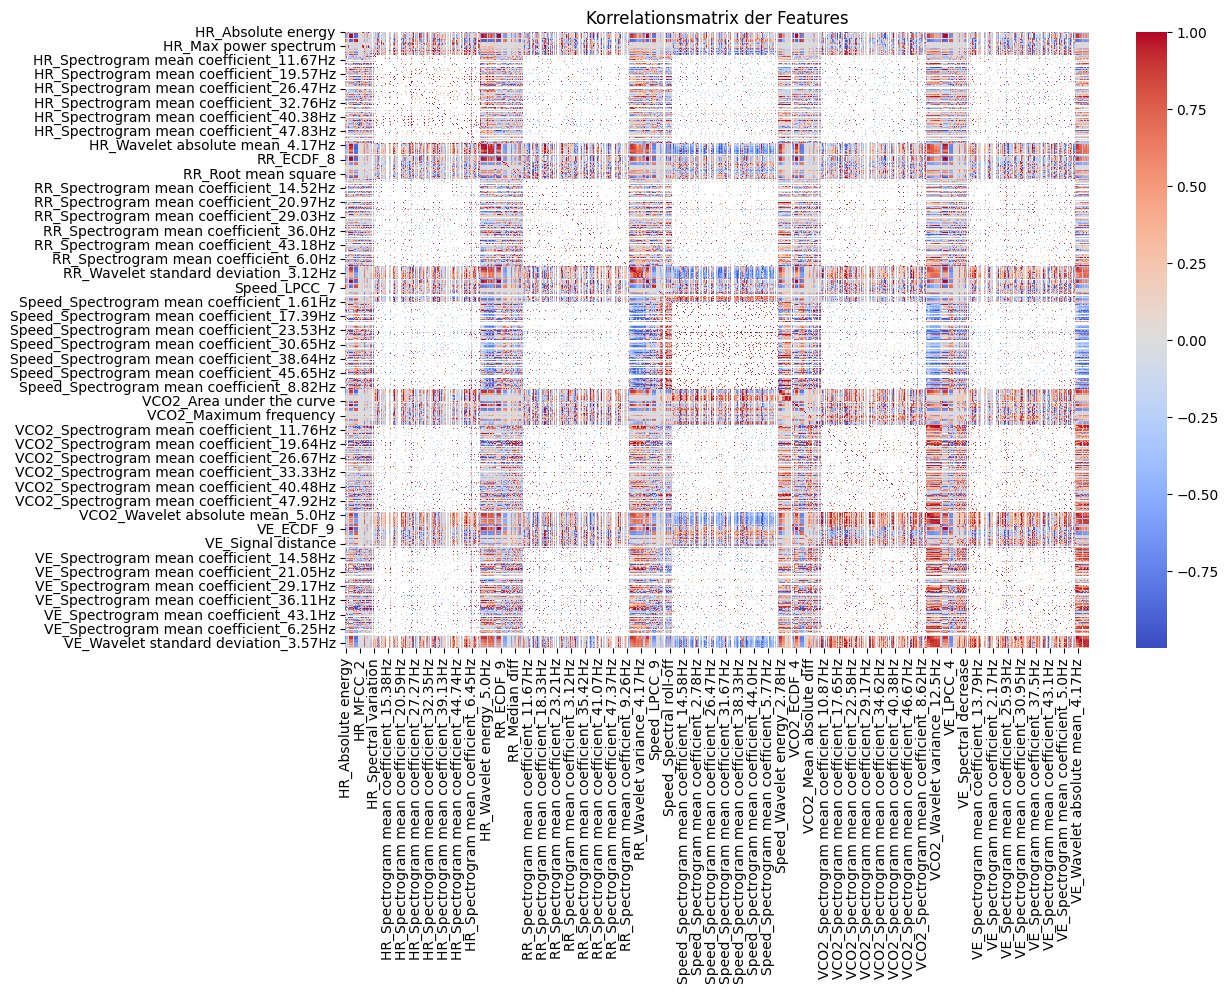


Stark korrelierte Feature-Paare:
       HR_Absolute energy                                                   \
  HR_Area under the curve HR_Centroid HR_ECDF Percentile Count_1 HR_ECDF_0   
0                0.977171    0.865846                   0.882131 -0.713532   

                                                               ...  \
  HR_ECDF_1 HR_ECDF_2 HR_ECDF_3 HR_ECDF_4 HR_ECDF_5 HR_ECDF_6  ...   
0 -0.713532 -0.713532 -0.713532 -0.713532 -0.713532 -0.713532  ...   

                                  VO2_max  \
  VE_Spectrogram mean coefficient_42.11Hz   
0                                0.791106   

                                           \
  VE_Spectrogram mean coefficient_42.31Hz   
0                                0.828122   

                                           \
  VE_Spectrogram mean coefficient_42.59Hz   
0                               -0.907727   

                                           \
  VE_Spectrogram mean coefficient_44.74Hz   
0                     

In [67]:
# test correlation

corr_pairs_tsfl = correlated_features(all_features_train,threshold=0.7)

In [69]:
# remove high correlated features
reduced_tsfl = remove_correlated_features(all_features_train,corr_pairs_tsfl)

# remove features with more than 50% Nans
cleaned_reduced_tsfl = remove_nan_features(reduced_tsfl)

Features to keep: ['HR_Spectrogram mean coefficient_33.87Hz', 'HR_Spectrogram mean coefficient_37.1Hz', 'VCO2_Spectrogram mean coefficient_1.61Hz', 'VCO2_Spectrogram mean coefficient_11.29Hz', 'VCO2_Spectrogram mean coefficient_12.9Hz', 'VCO2_Spectrogram mean coefficient_14.52Hz', 'VCO2_Spectrogram mean coefficient_19.35Hz', 'VCO2_Spectrogram mean coefficient_22.58Hz', 'VCO2_Spectrogram mean coefficient_24.19Hz', 'VCO2_Spectrogram mean coefficient_25.81Hz', 'VCO2_Spectrogram mean coefficient_3.23Hz', 'VCO2_Spectrogram mean coefficient_30.65Hz', 'VCO2_Spectrogram mean coefficient_32.26Hz', 'VCO2_Spectrogram mean coefficient_35.48Hz', 'VCO2_Spectrogram mean coefficient_4.84Hz', 'VCO2_Spectrogram mean coefficient_40.32Hz', 'VCO2_Spectrogram mean coefficient_43.55Hz', 'VCO2_Spectrogram mean coefficient_6.45Hz', 'VCO2_Spectrogram mean coefficient_8.06Hz', 'VCO2_Spectrogram mean coefficient_9.68Hz']
Features to drop: ['HR_Absolute energy', 'HR_Area under the curve', 'HR_Autocorrelation', 'HR

In [73]:
reduced_tsfl['VO2_max']

KeyError: 'VO2_max'

In [72]:
# mutual information scores

info_tsfl = mutual_information_FS(reduced_tsfl, 'VO2_max')

KeyError: "['VO2_max'] not found in axis"